In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


In [3]:
print(pd.__version__)

0.23.4


In [4]:
%matplotlib widget

## Property Data

In [5]:
id_halo = '17'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

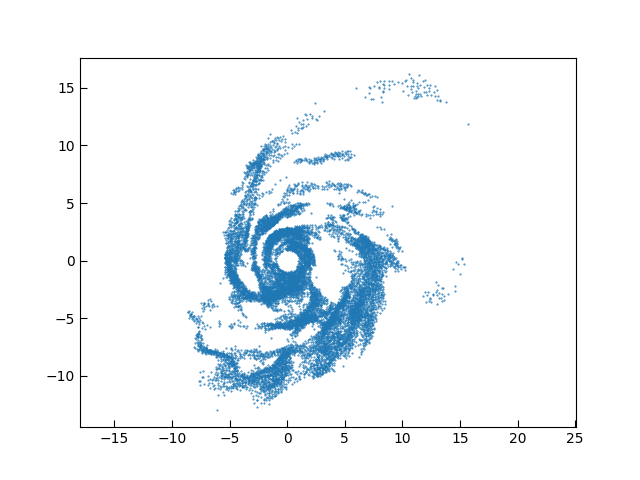

In [6]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [7]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [8]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


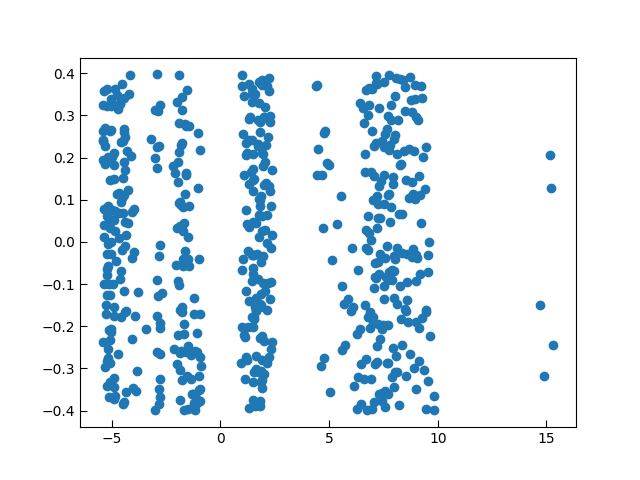

In [9]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


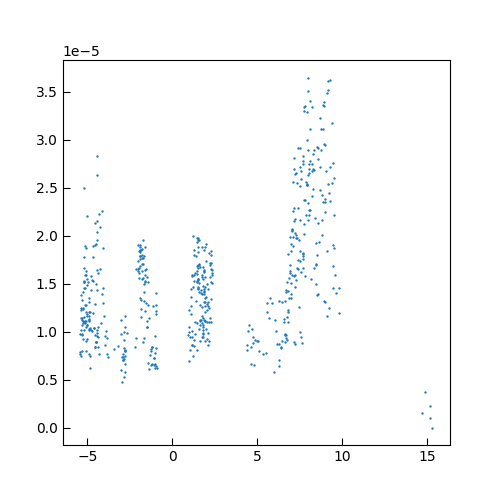

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [11]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

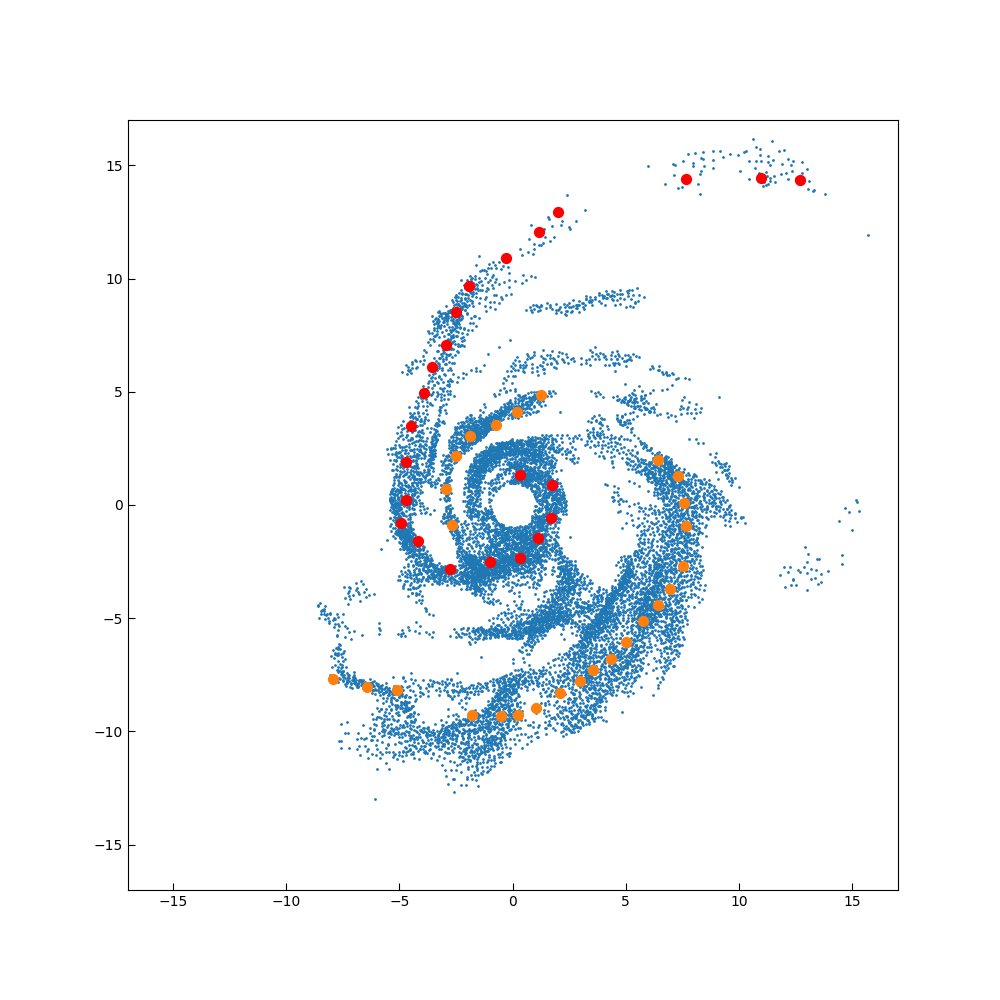

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 17
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [13]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [14]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [15]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [16]:
b = 0.3

In [17]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

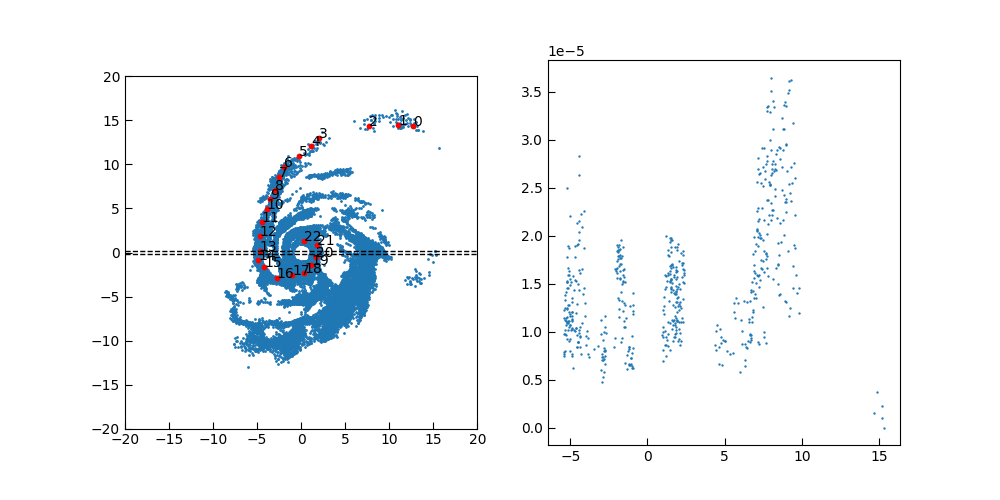

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

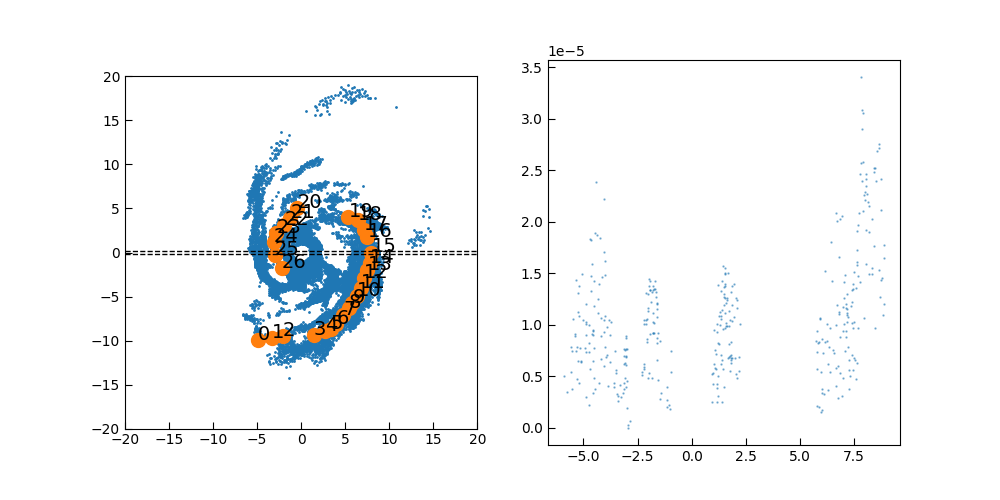

In [19]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 15
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [20]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [21]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [22]:
arm = df_arm2.copy(deep=True)

In [23]:
arm

x         y  arm  id  \
0  -7.915584 -7.670455    2   0   
1  -6.409091 -8.034091    2   1   
2  -5.110390 -8.189935    2   2   
3  -1.785714 -9.280844    2   3   
4  -0.487013 -9.332792    2   4   
5   0.240260 -9.280844    2   5   
6   1.019481 -8.969156    2   6   
7   2.110390 -8.293831    2   7   
8   2.993506 -7.774351    2   8   
9   3.564935 -7.306818    2   9   
10  4.344156 -6.787338    2  10   
11  5.019481 -6.060065    2  11   
12  5.746753 -5.125000    2  12   
13  6.422078 -4.397727    2  13   
14  6.941558 -3.722403    2  14   
15  7.512987 -2.683442    2  15   
16  7.668831 -0.917208    2  16   
17  7.564935  0.069805    2  17   
18  7.305195  1.264610    2  18   
19  6.422078  1.991883    2  19   
20  1.279221  4.849026    2  20   
21  0.188312  4.121753    2  21   
22 -0.746753  3.550325    2  22   
23 -1.889610  3.030844    2  23   
24 -2.512987  2.147727    2  24   
25 -2.928571  0.693182    2  25   
26 -2.668831 -0.865260    2  26   

                                        rotation_info  \
0   ({'x_rot': [0.9298452455868048, 0.997775879034...   
1   ({'x_rot': [0.9646997401459014, 1.014046605595...   
2   ({'x_rot': [0.9826837995777098, 1.014531307473...   
3   ({'x_rot': [0.9526559161601696, 0.927111292248...   
4   ({'x_rot': [0.907755708792362, 0.8611568615333...   
5   ({'x_rot': [0.8746585834859029, 0.816519425822...   
6   ({'x_rot': [0.8313271974050929, 0.760697589909...   
7   ({'x_rot': [0.7513538913213068, 0.662373044509...   
8   ({'x_rot': [0.6703765718490534, 0.566746090007...   
9   ({'x_rot': [0.6053140420666216, 0.491900953410...   
10  ({'x_rot': [0.5114007093053738, 0.386244674759...   
11  ({'x_rot': [0.4043955312241919, 0.268608738402...   
12  ({'x_rot': [0.2644608805891753, 0.118387786670...   
13  ({'x_rot': [0.14098779488008423, -0.0112174093...   
14  ({'x_rot': [0.034581432957190794, -0.120876466...   
15  ({'x_rot': [-0.11250265275206267, -0.269458655...   
16  ({'x_rot': [-0.32767340904242337, -0.480341415...   
17  ({'x_rot': [-0.4441635032868997, -0.5909118817...   
18  ({'x_rot': [-0.5807843747267021, -0.7166123103...   
19  ({'x_rot': [-0.678973143372351, -0.80351985868...   
20  ({'x_rot': [-0.9681385980761296, -0.9531524106...   
21  ({'x_rot': [-0.9052144003226474, -0.8576452377...   
22  ({'x_rot': [-0.7775195404344142, -0.6940269731...   
23  ({'x_rot': [-0.5213768394906302, -0.3973520395...   
24  ({'x_rot': [-0.24434108693226814, -0.097089345...   
25  ({'x_rot': [0.22015230468462668, 0.37596674521...   
26  ({'x_rot': [0.6880726413797038, 0.811389968328...   

                                      rotation_coords     alpha  \
0   {'x_rot': [0.9298452455868048, 0.9977758790343...  3.911265   
1   {'x_rot': [0.9646997401459014, 1.0140466055955...  4.039029   
2   {'x_rot': [0.9826837995777098, 1.0145313074731...  4.154521   
3   {'x_rot': [0.9526559161601696, 0.9271112922488...  4.522303   
4   {'x_rot': [0.907755708792362, 0.86115686153335...  4.660253   
5   {'x_rot': [0.8746585834859029, 0.8165194258227...  4.738271   
6   {'x_rot': [0.8313271974050929, 0.7606975899091...  4.825568   
7   {'x_rot': [0.7513538913213068, 0.6623730445095...  4.961554   
8   {'x_rot': [0.6703765718490534, 0.5667460900073...  5.079941   
9   {'x_rot': [0.6053140420666216, 0.4919009534107...  5.166303   
10  {'x_rot': [0.5114007093053738, 0.3862446747599...  5.281729   
11  {'x_rot': [0.4043955312241919, 0.2686087384028...  5.404142   
12  {'x_rot': [0.2644608805891753, 0.1183877866706...  5.554915   
13  {'x_rot': [0.14098779488008423, -0.01121740938...  5.682746   
14  {'x_rot': [0.034581432957190794, -0.1208764667...  5.790961   
15  {'x_rot': [-0.11250265275206267, -0.2694586558...  5.940134   
16  {'x_rot': [-0.32767340904242337, -0.4803414154...  6.164149   
17  {'x_rot': [-0.4441635032868997, -0.59091188179...  0.009227   
18  {'x_rot': [-0.5807843747267021, -0.71661231031...  0.171412   
19  {'x_rot': [-0.678973143372351, -0.803519858683...  0.300753   
20  {'x_rot': [-0.96813859

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Función para procesar antes del clicker y devolver el clicker
def process_before_clicker(arm, n, clicker):
    print(f"Processing point {n} before clicker...")
    
    fig, (ax, ax2) = plt.subplots(figsize=(7, 7), ncols=2)
    
    x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
    y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
    ax.axvline(x=x_tracing, lw=1, ls='--', color='red')
    
    x_band = arm.iloc[n].rotated_arm_profile['x_band']
    y_band = arm.iloc[n].rotated_arm_profile['y_band']
    ax.scatter(x_band, y_band, s=3, alpha=1)
    ax.set_xlim(x_tracing-2, x_tracing+2)
    
    # Clicker setup
    klicker = clicker(ax, ["limits"], markers=["o"], colors=['red'], markersize=2)
    
    x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
    y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
    x_coords = arm.iloc[n].rotation_coords['x_rot']
    y_coords = arm.iloc[n].rotation_coords['y_rot']
    
    ax2.scatter(x_coords, y_coords, s=3)
    ax2.scatter(x_tracing_all, y_tracing_all, s=100)
    for x, y, id in zip(x_tracing_all, y_tracing_all, arm.id):
        ax2.text(x, y, str(int(id)), fontsize=14)
    
    ax2.axvline(x=x_tracing, lw=1, ls='--', color='red')
    ax2.axhline(y=2, ls='--', lw=1, color='black')
    ax2.axhline(y=-2, ls='--', lw=1, color='black')
    
    ax2.set_xlim(x_tracing-3, x_tracing+3)
    ax2.set_ylim(-2.5, 2.5)
    
    # Muestra la gráfica para permitir interacción con el clicker
    plt.show()
    
    return klicker



=== Processing point 1 ===


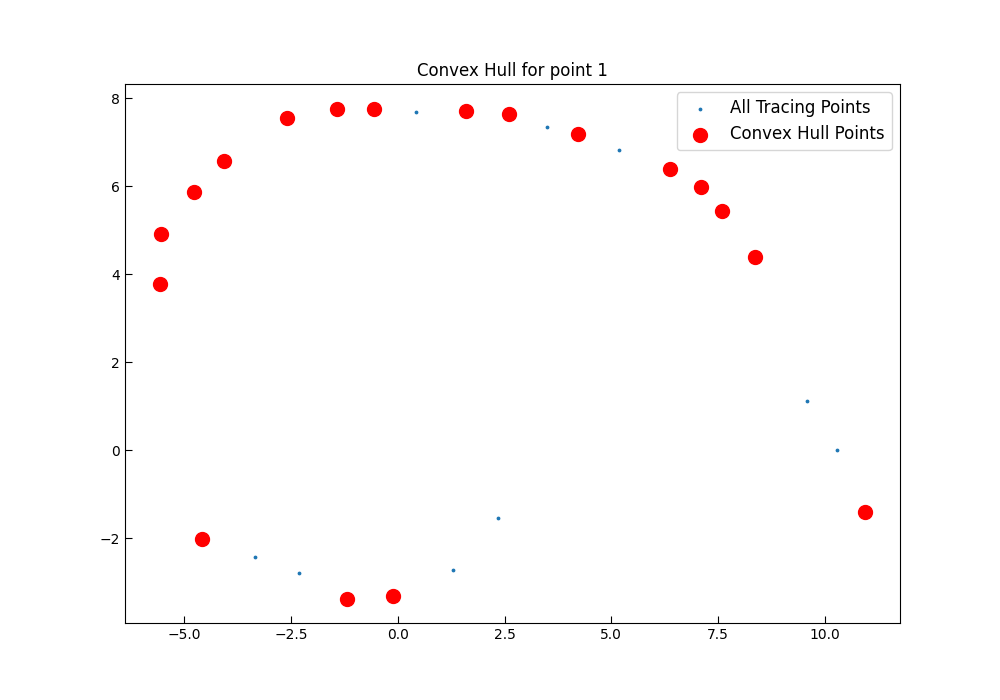

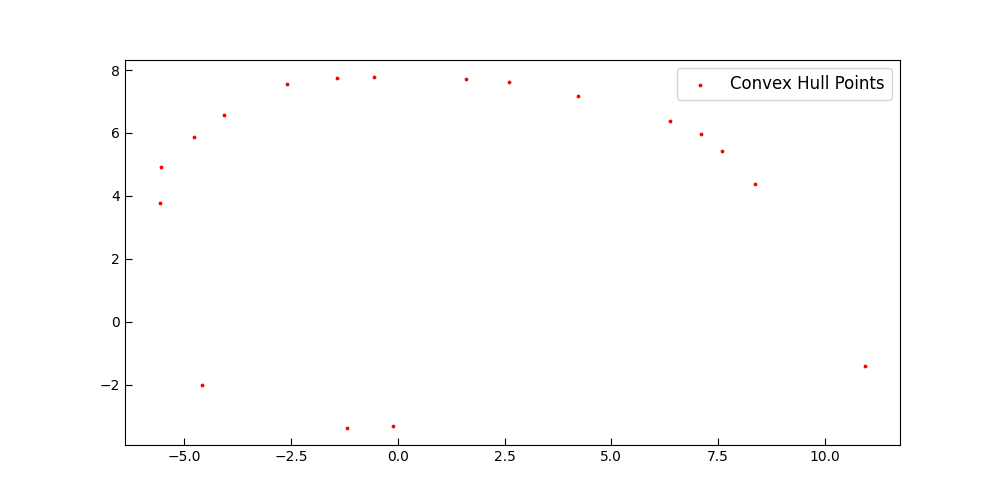


=== Processing point 2 ===


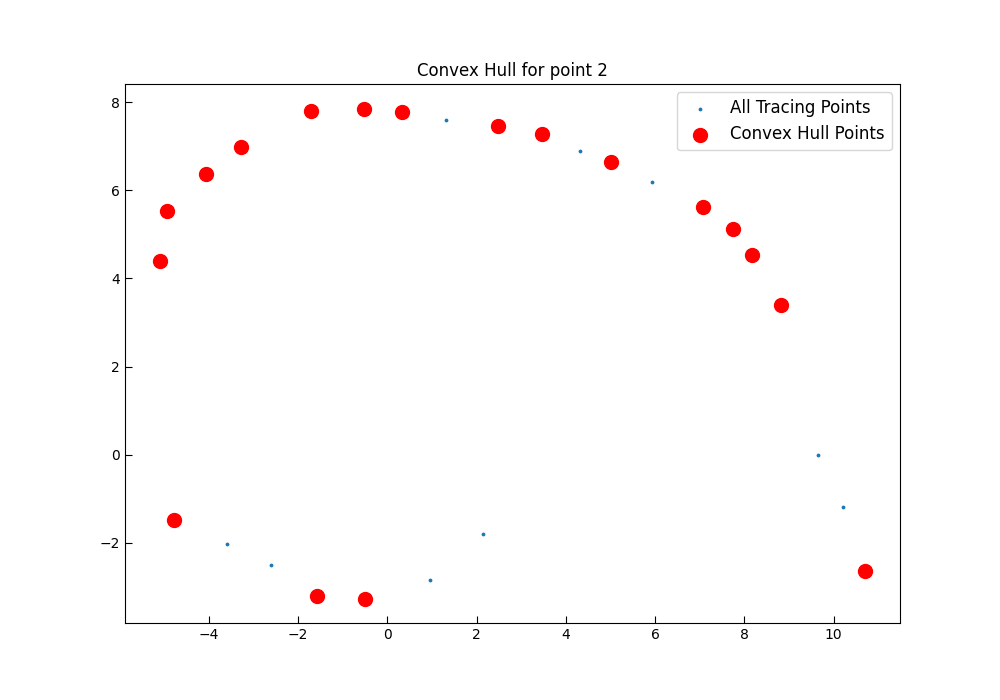

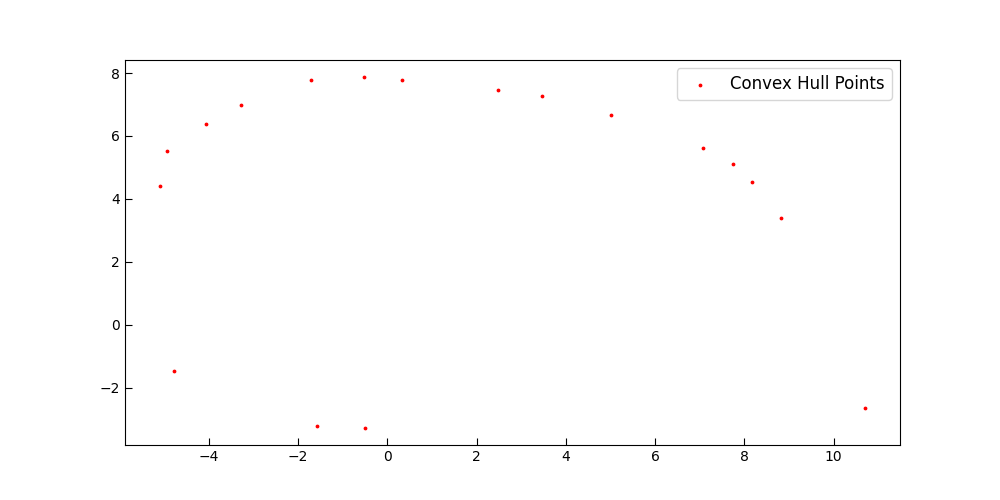


=== Processing point 3 ===


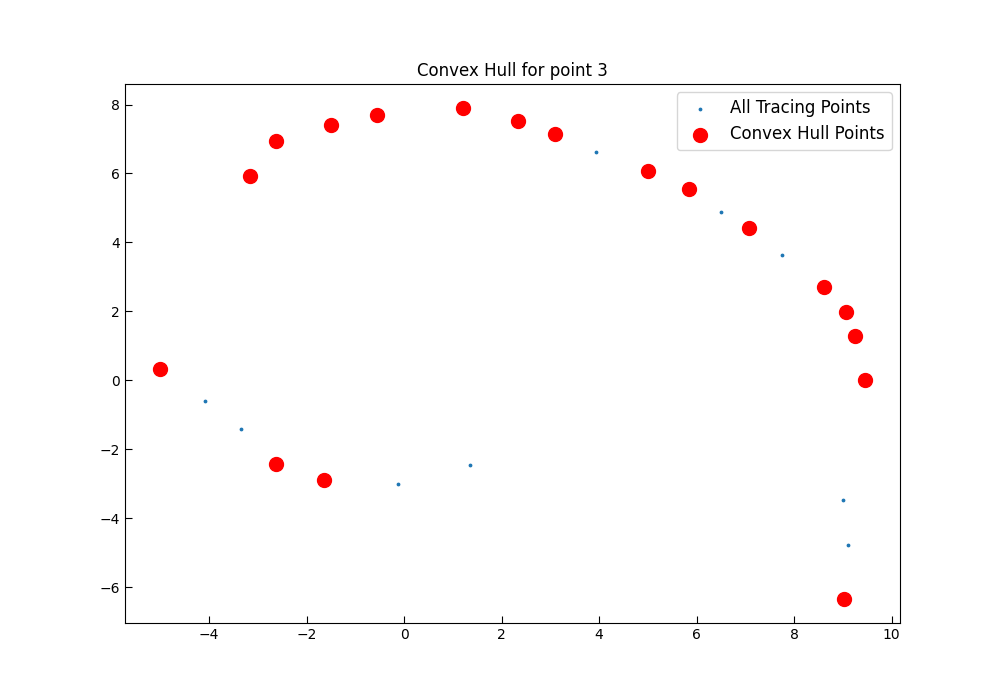

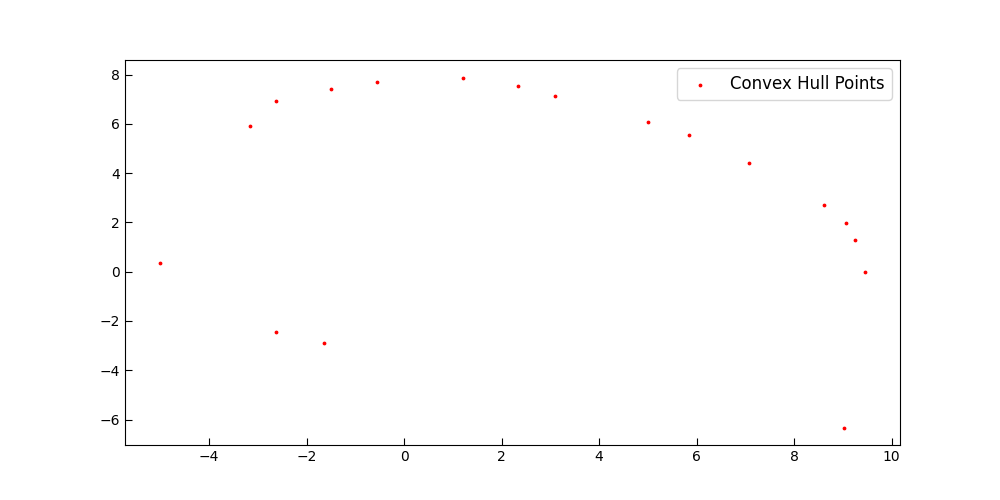


=== Processing point 4 ===


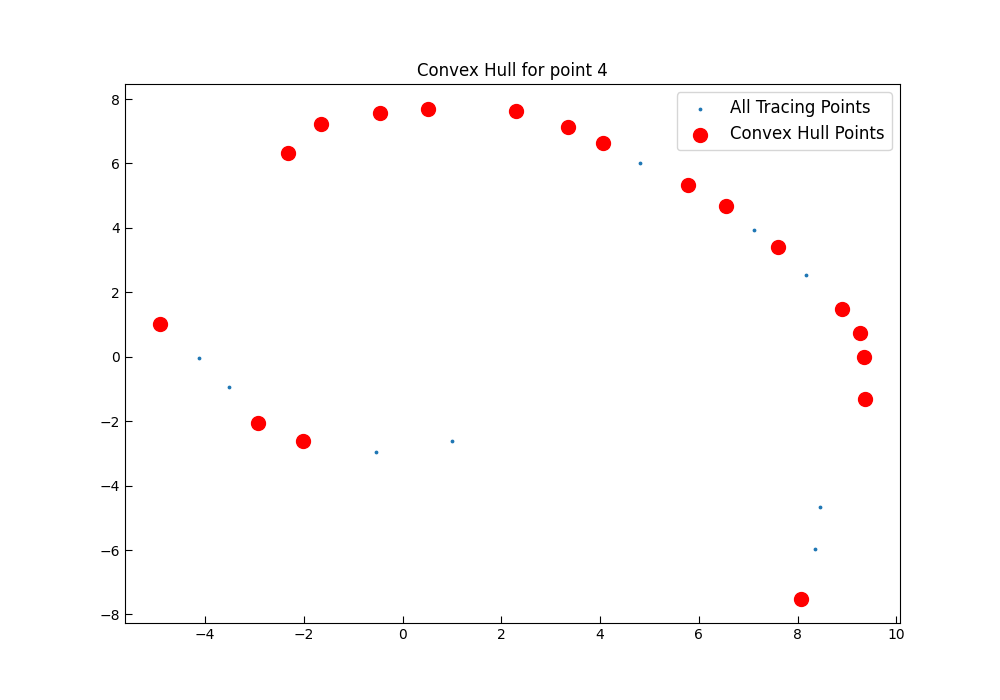

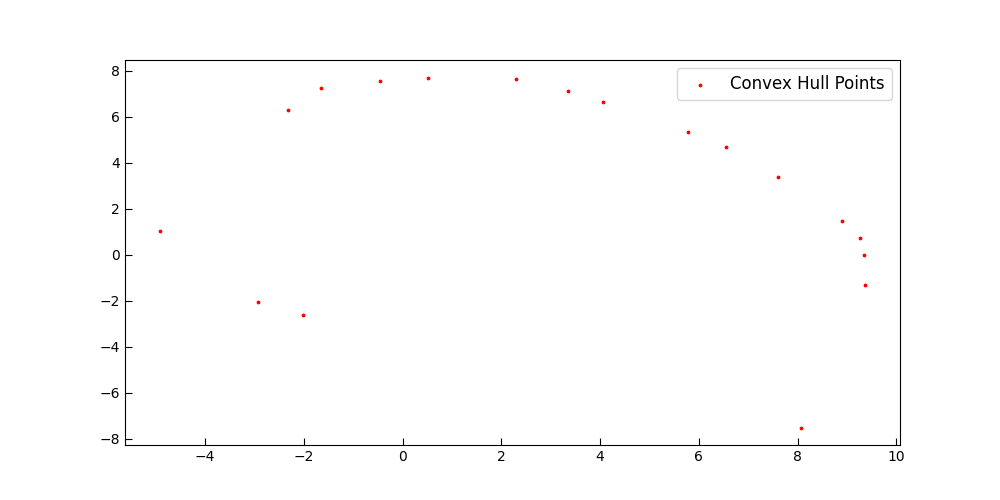


=== Processing point 5 ===


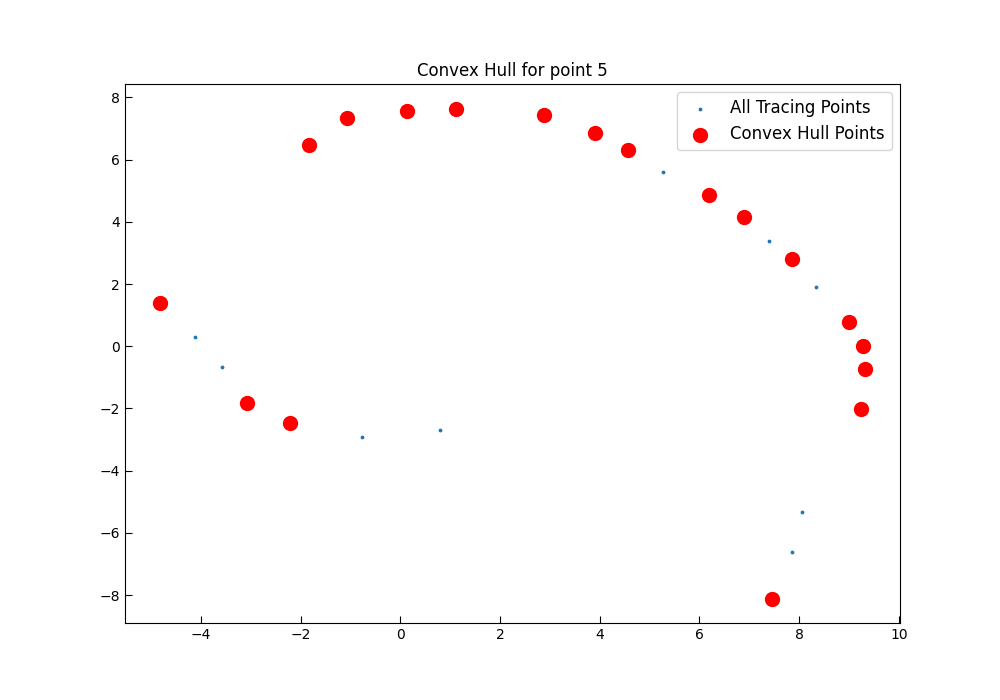

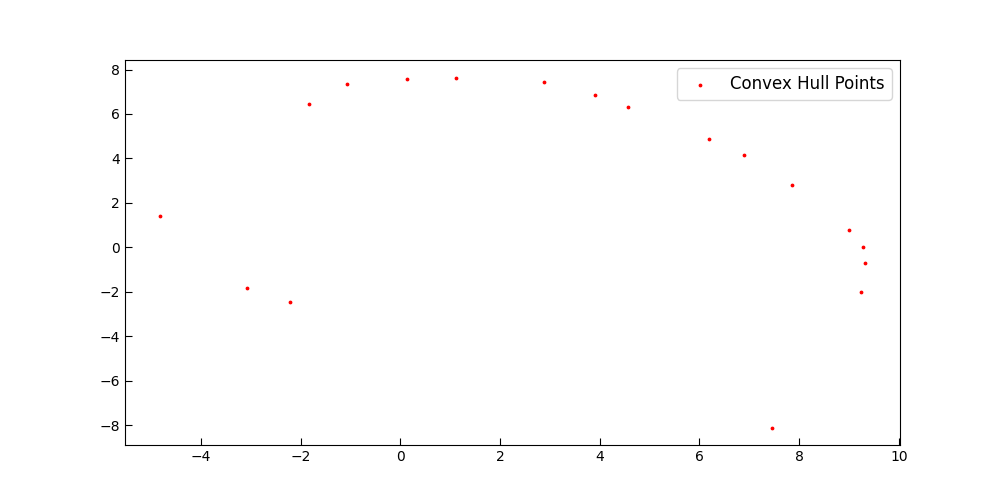


=== Processing point 6 ===


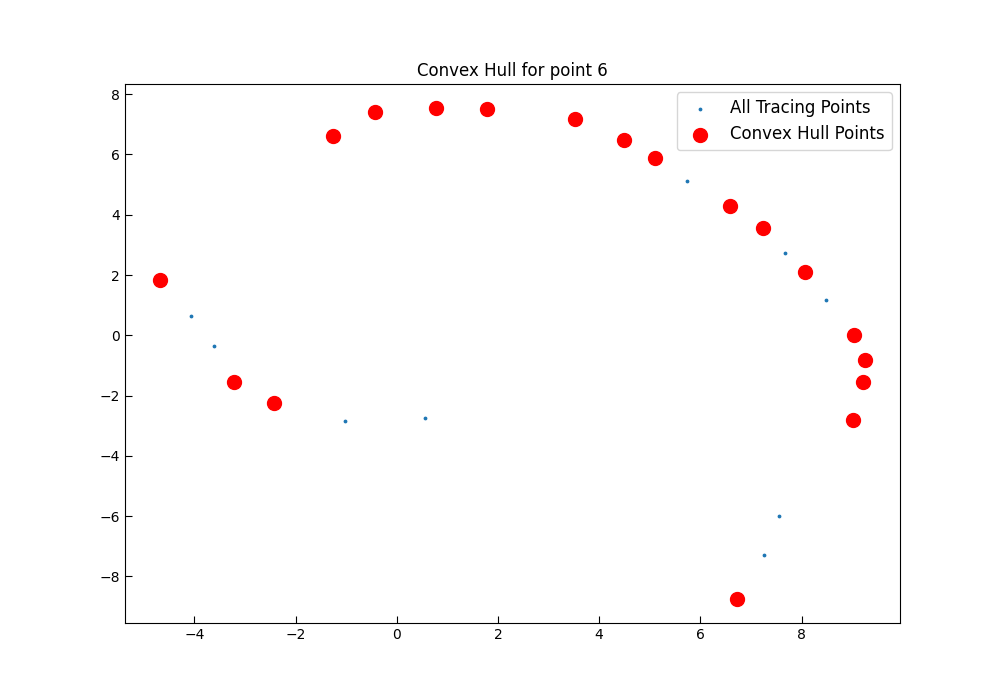

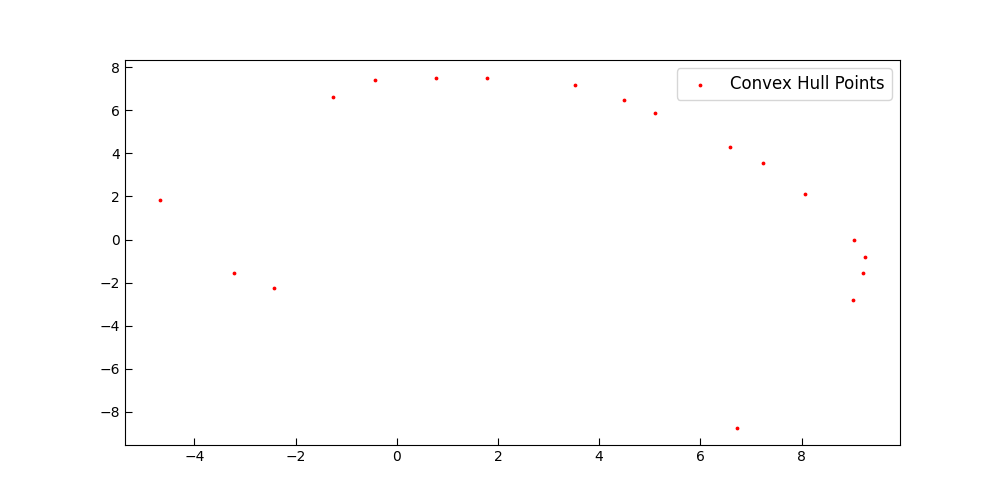


=== Processing point 7 ===


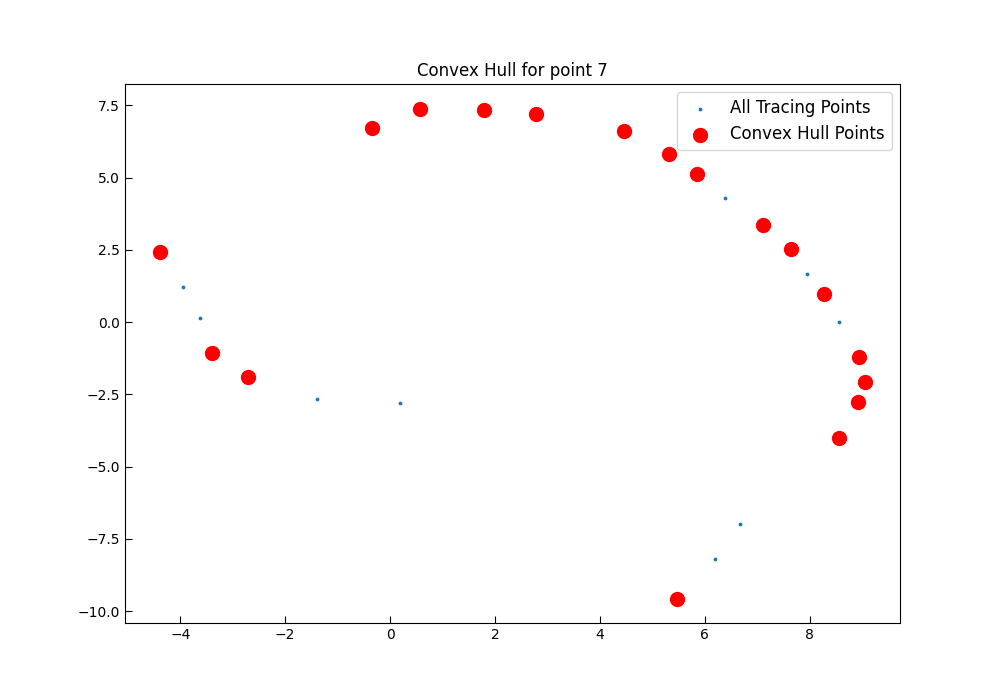

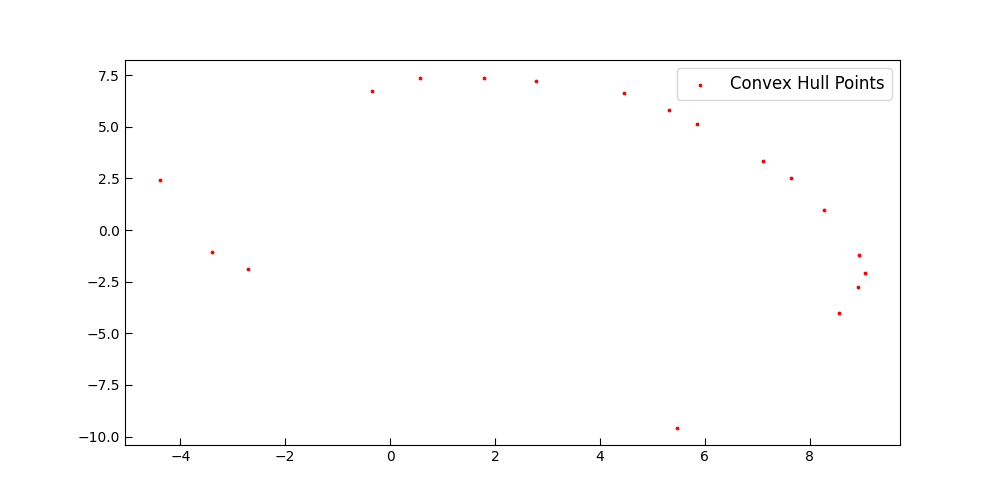


=== Processing point 8 ===


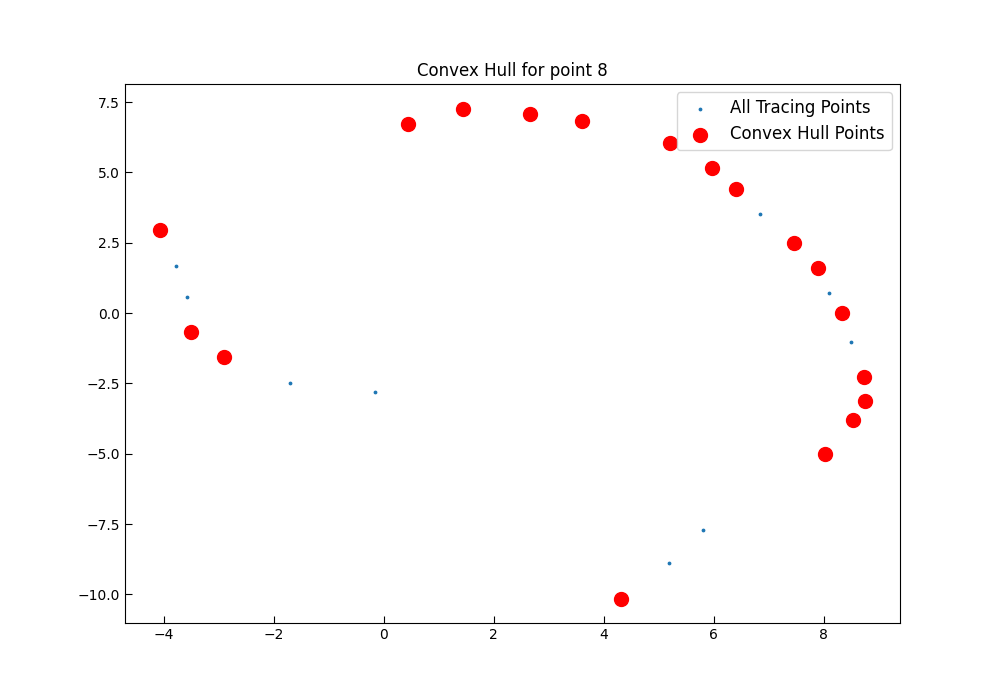

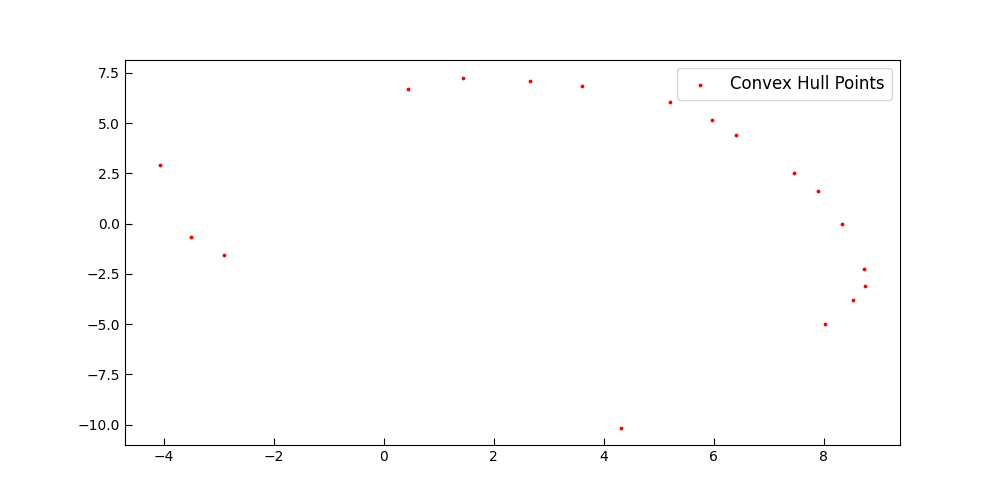


=== Processing point 9 ===


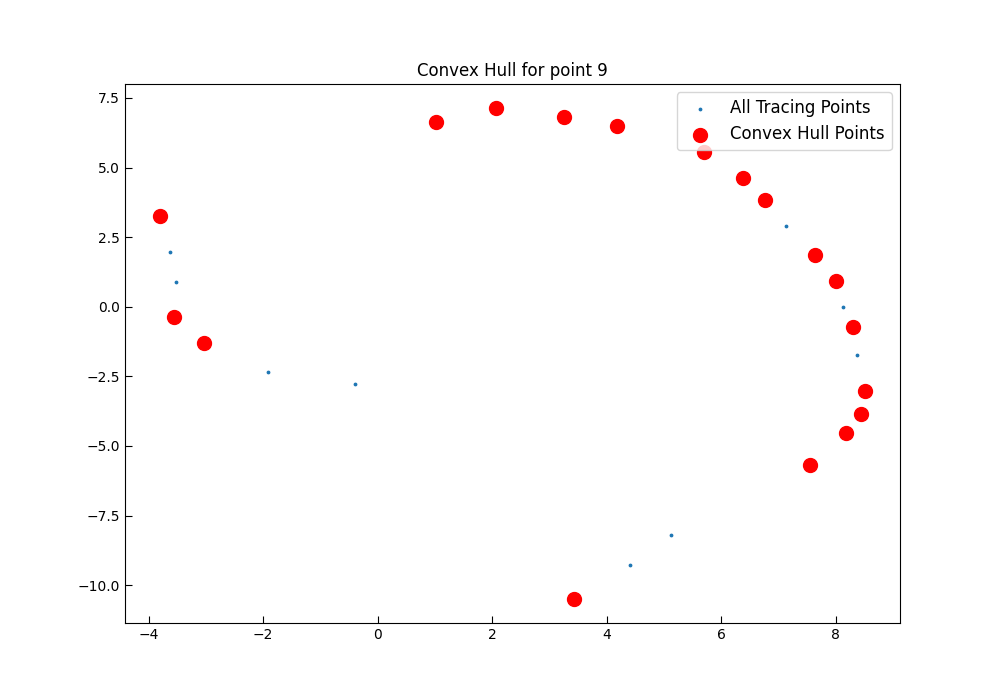

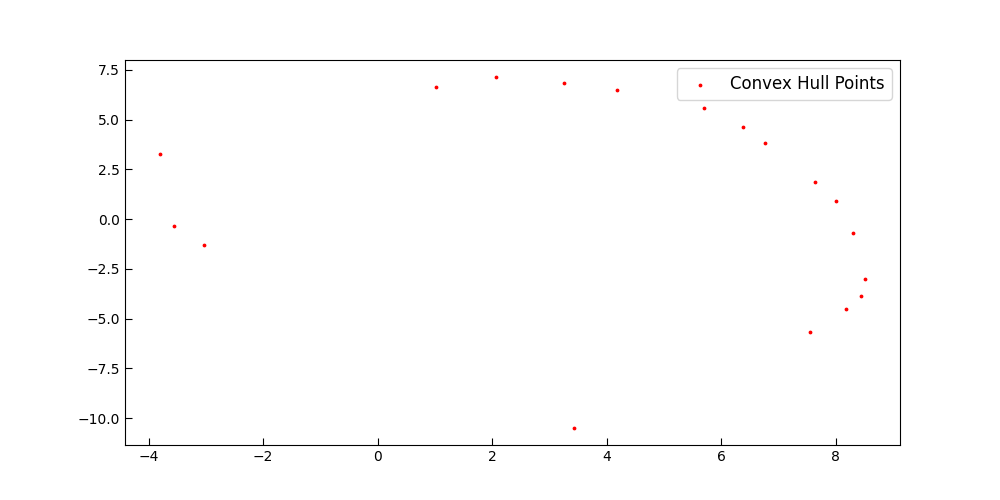


=== Processing point 10 ===


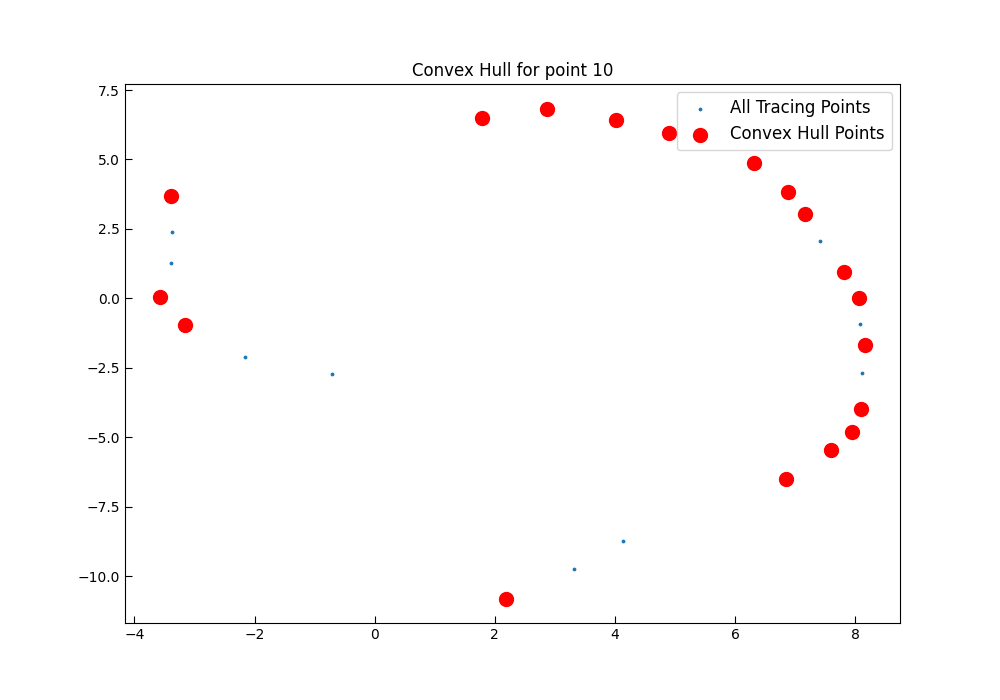

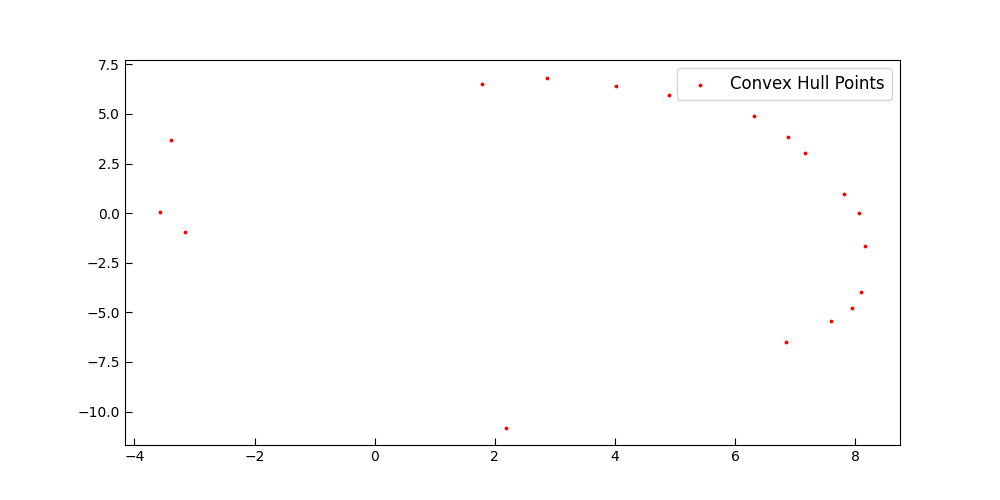


=== Processing point 11 ===


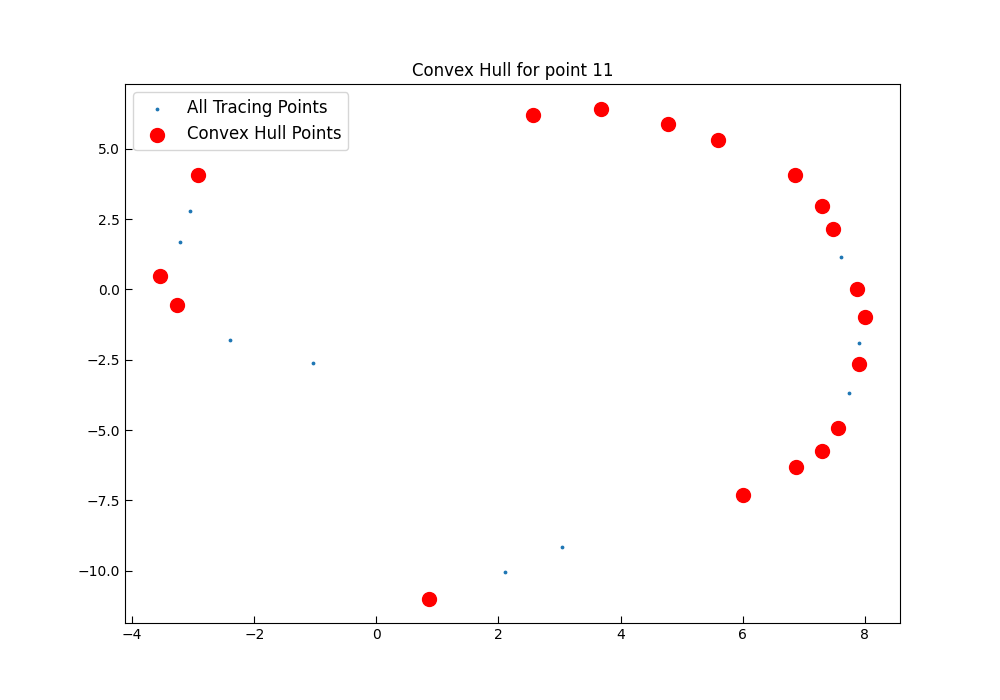

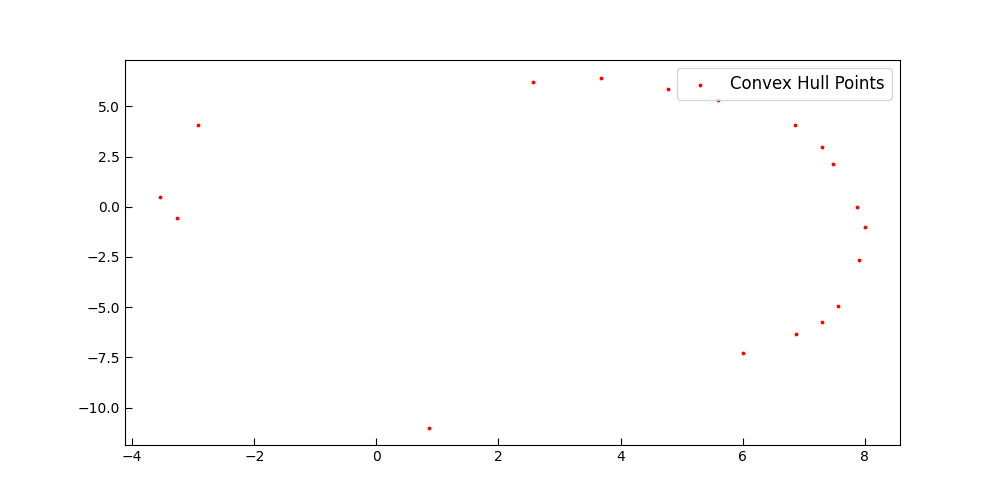


=== Processing point 12 ===


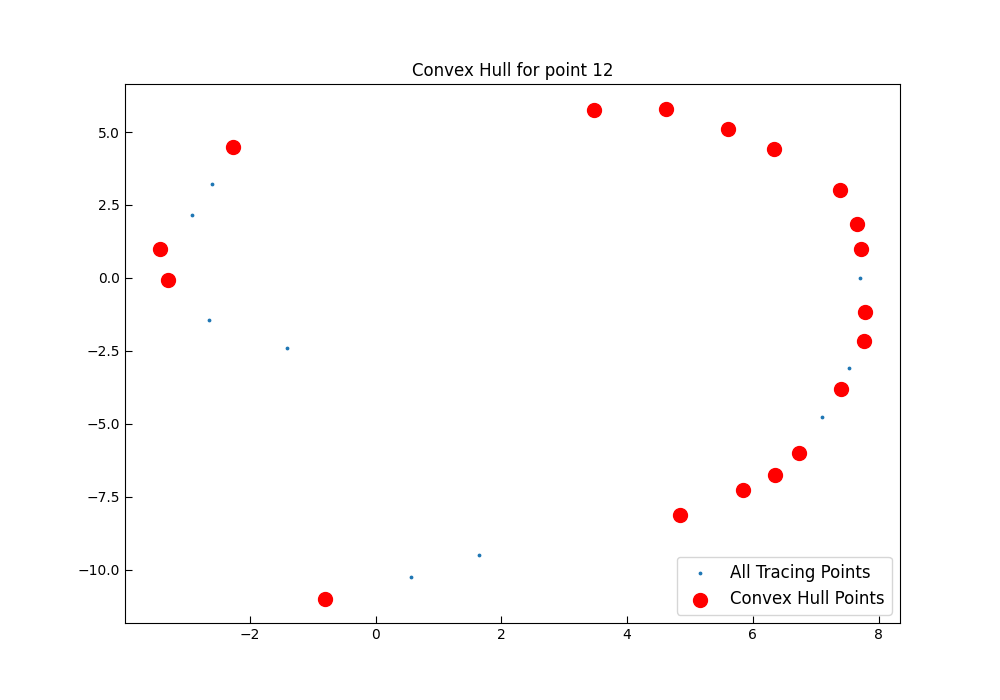

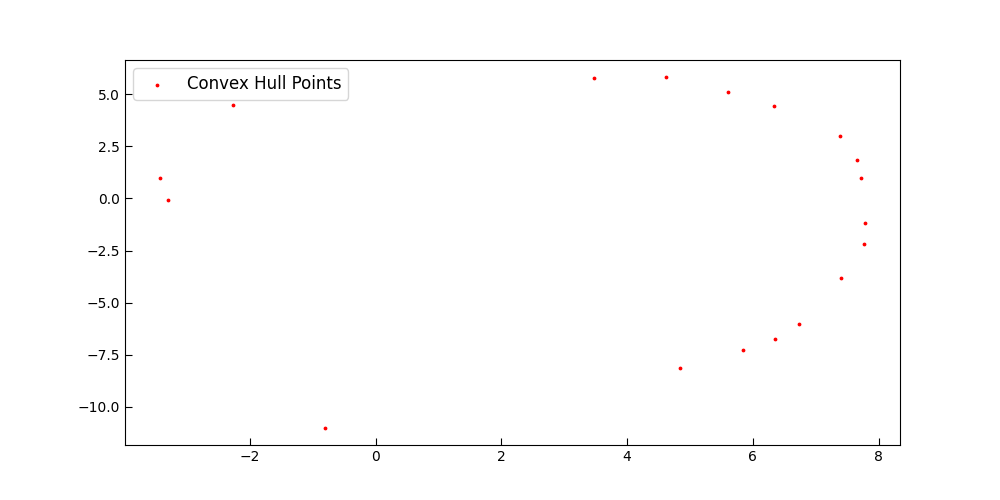


=== Processing point 13 ===


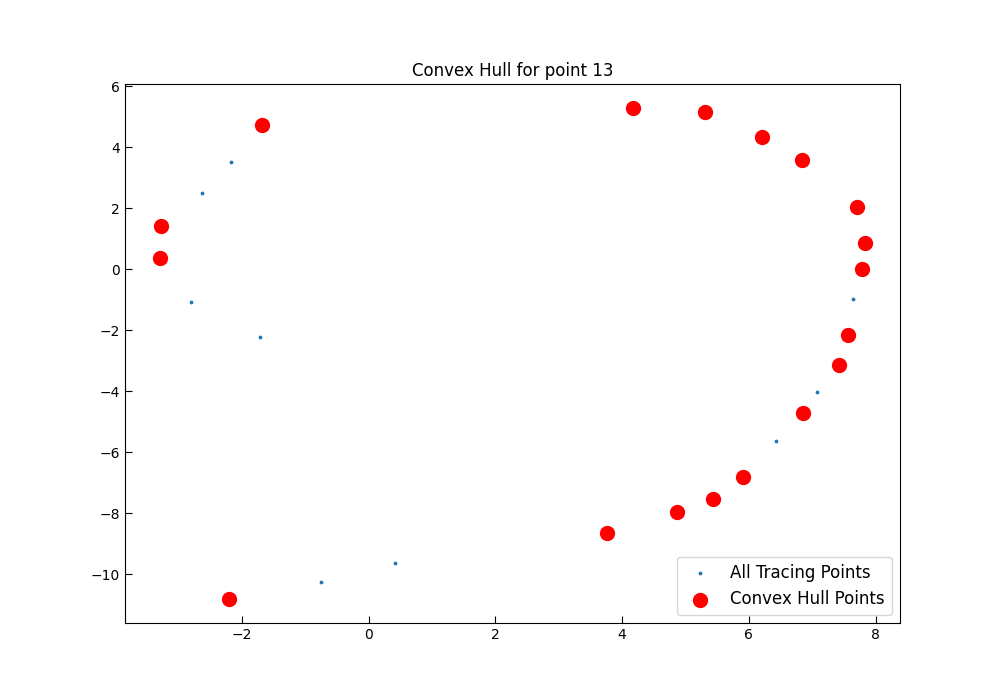

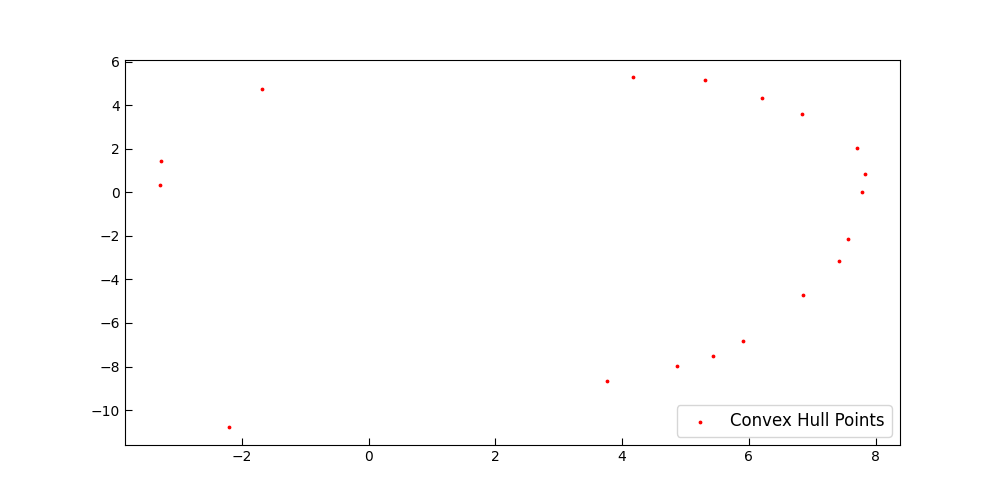


=== Processing point 14 ===


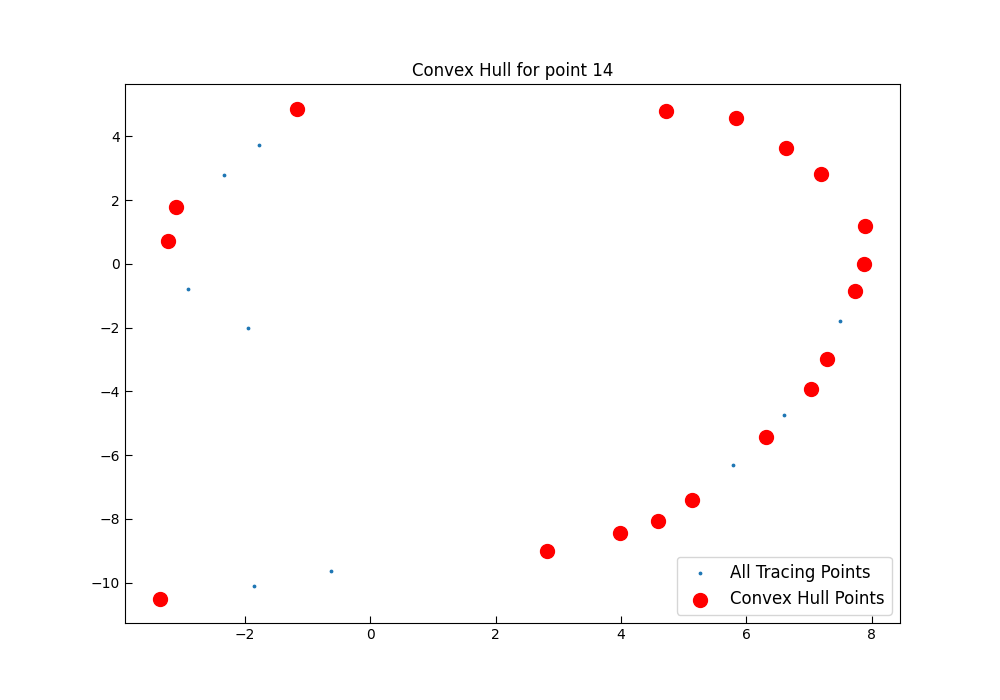

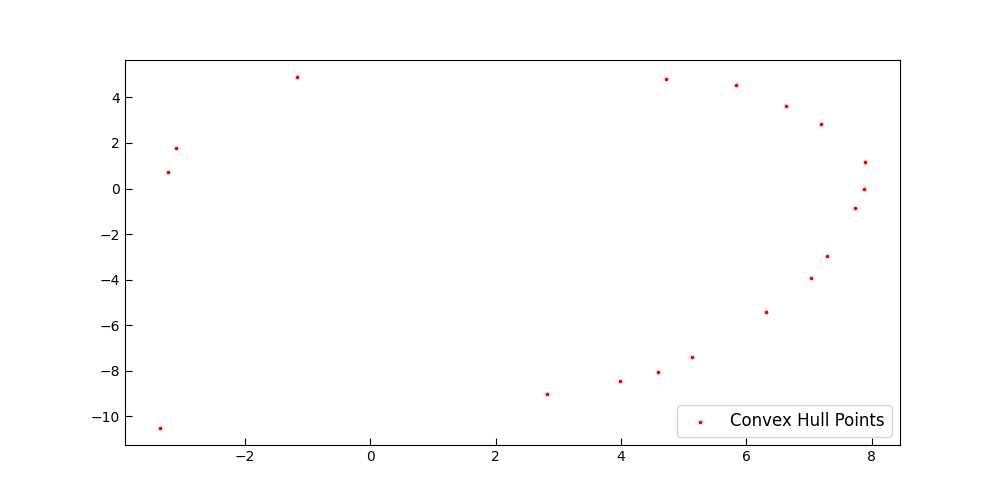


=== Processing point 15 ===


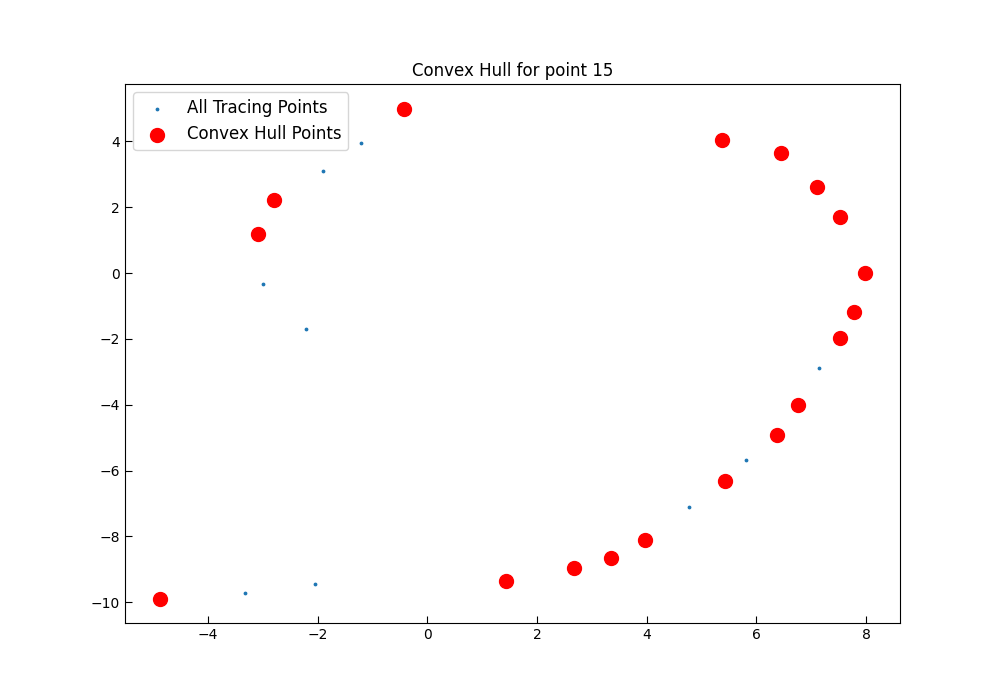

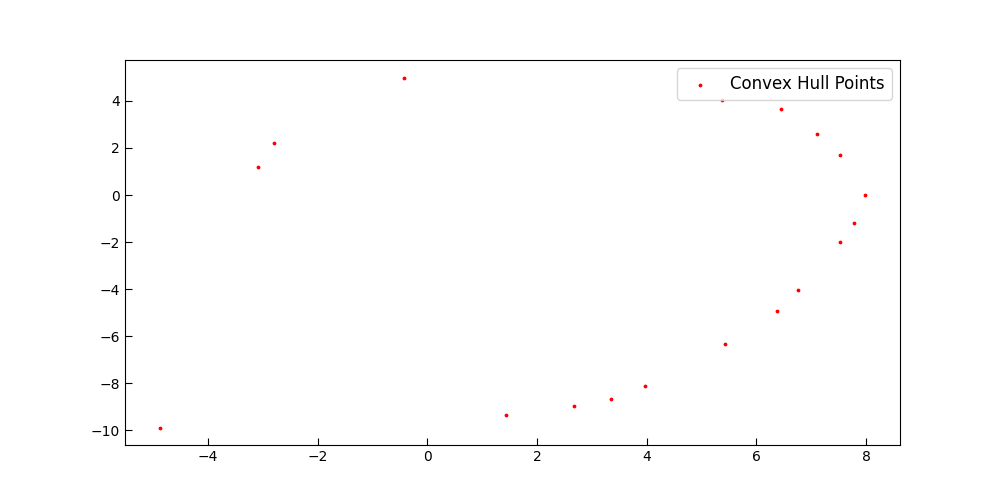


=== Processing point 16 ===


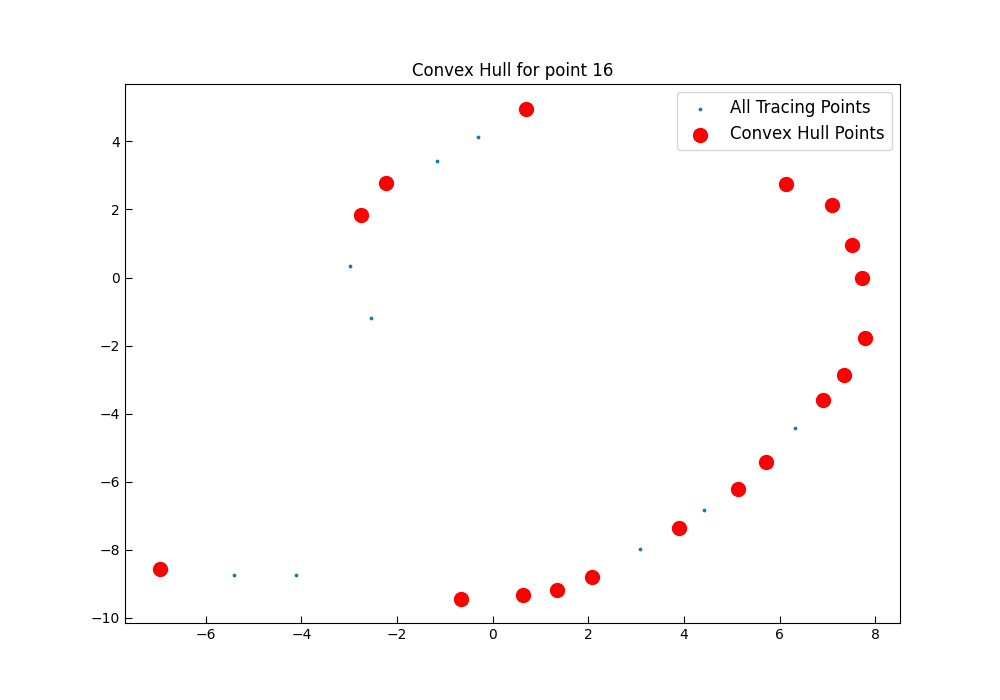

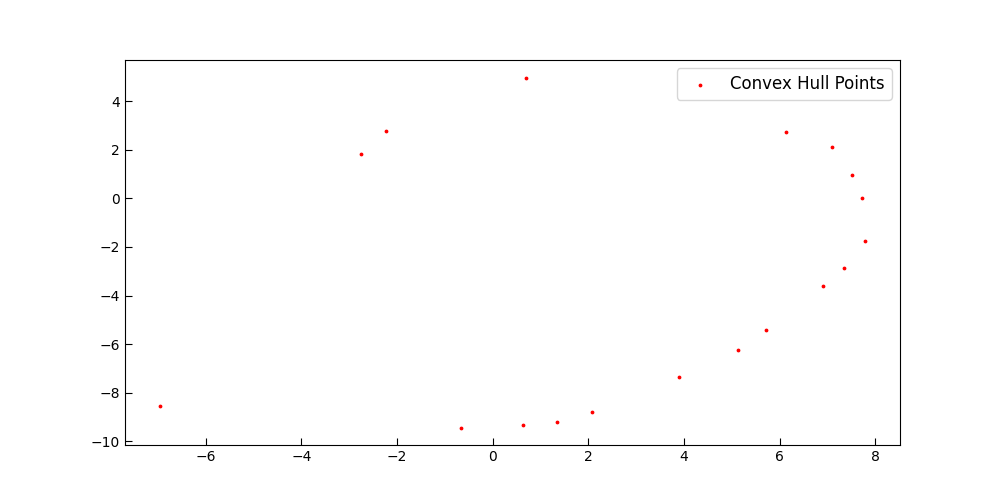


=== Processing point 17 ===


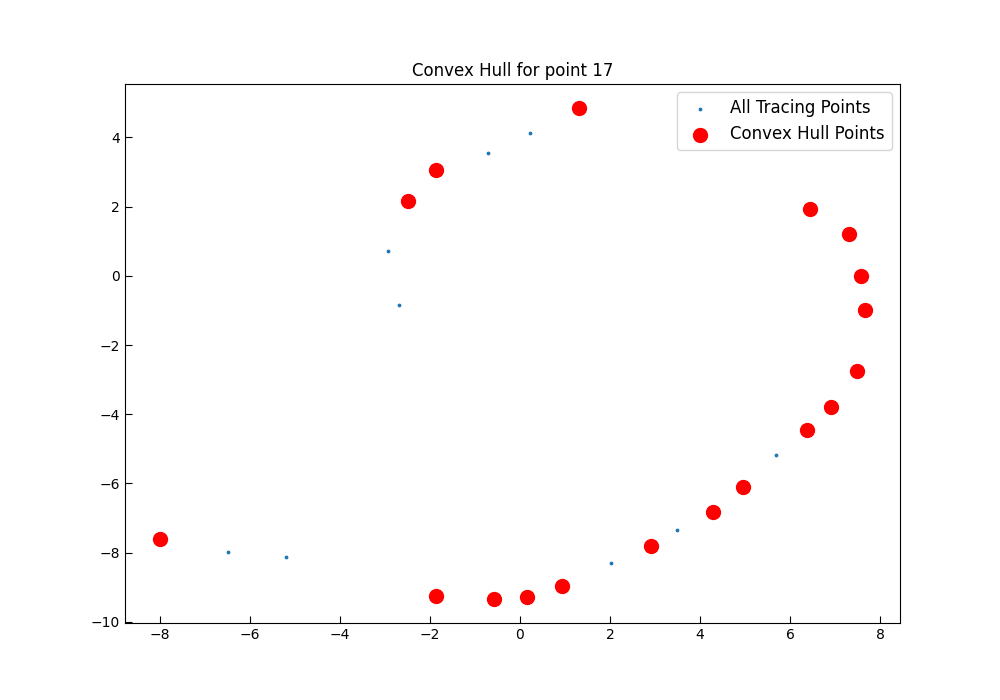

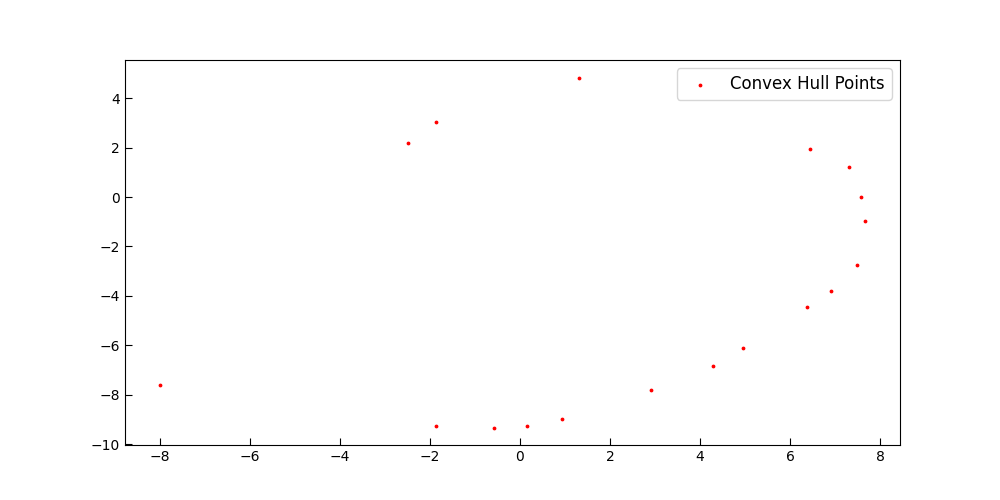


=== Processing point 18 ===


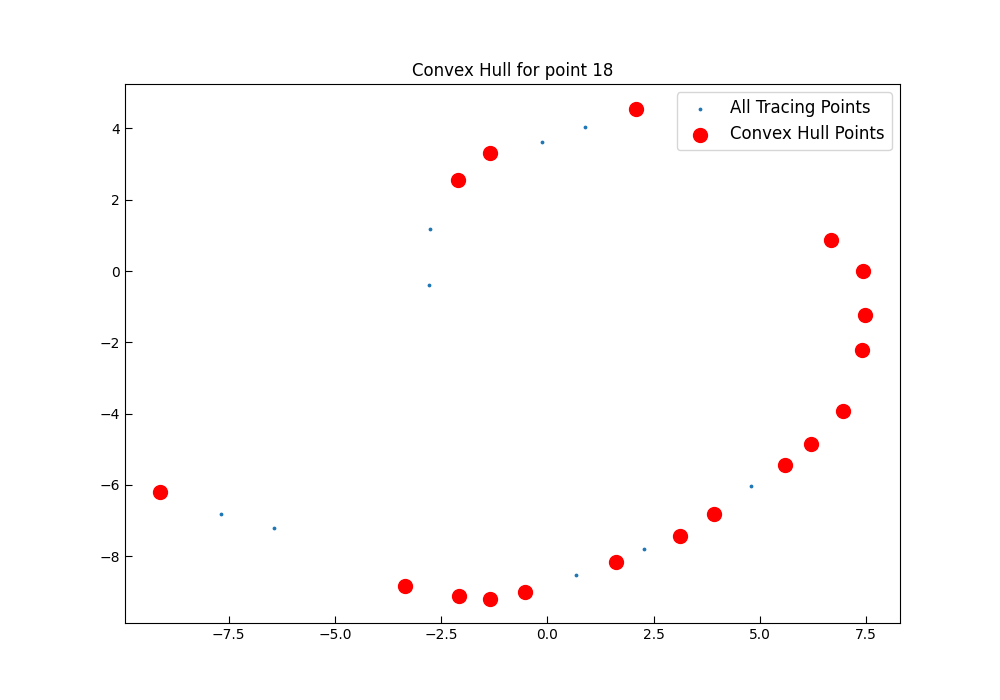

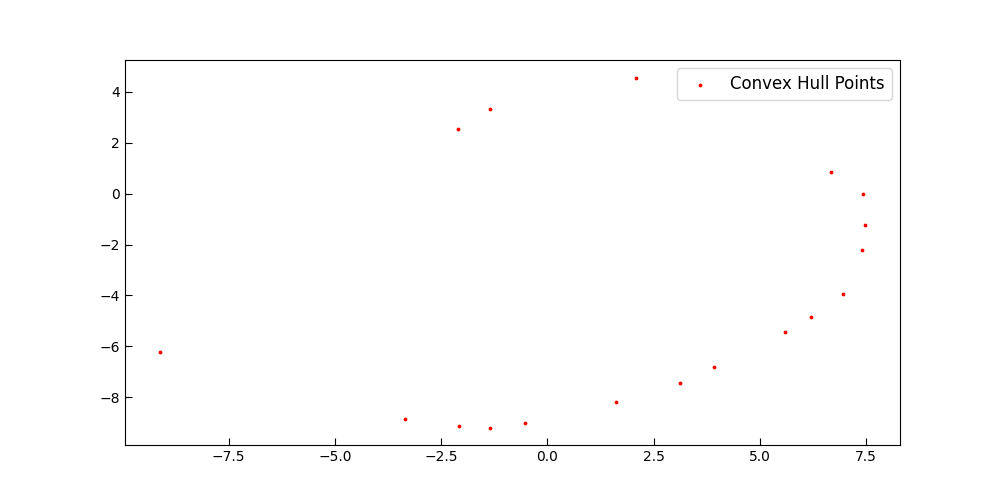


=== Processing point 19 ===


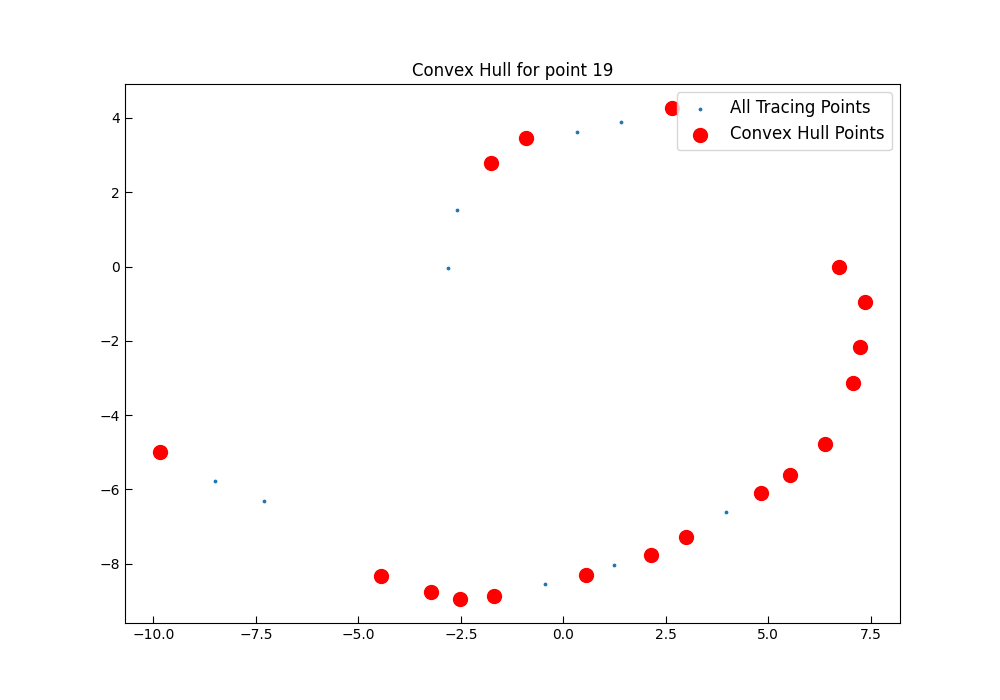

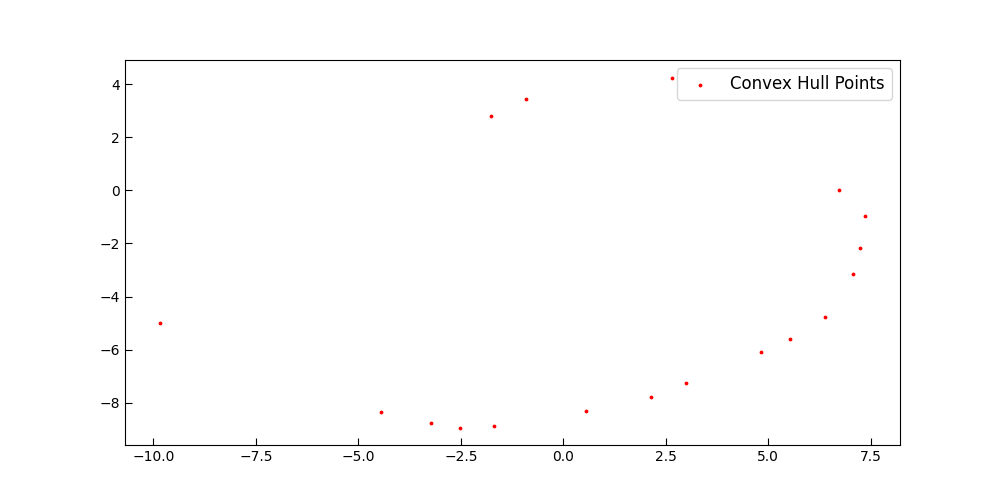


=== Processing point 20 ===


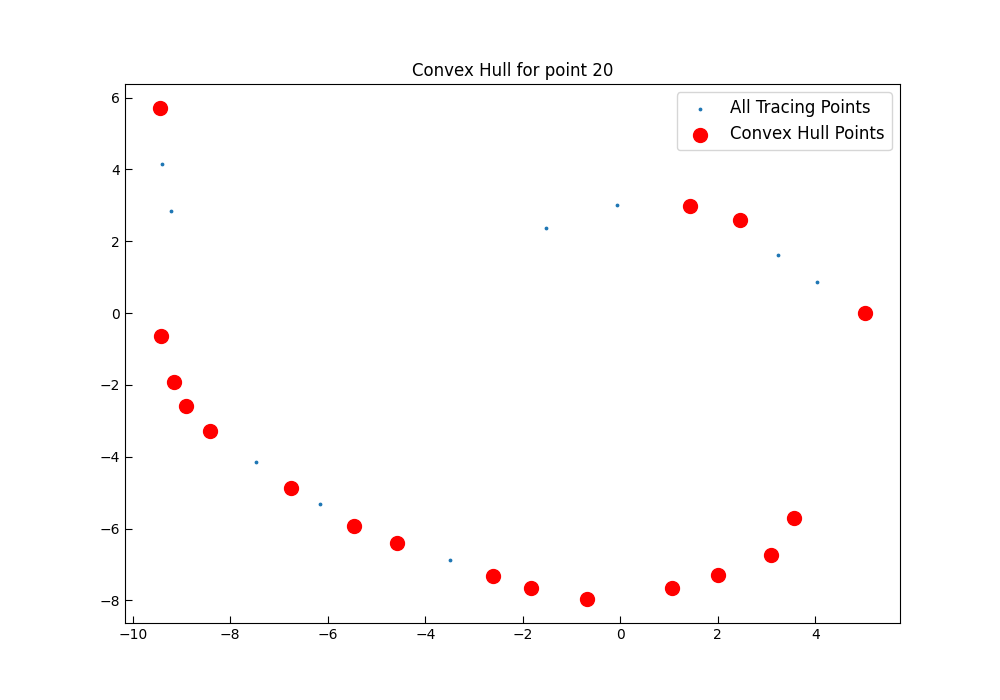

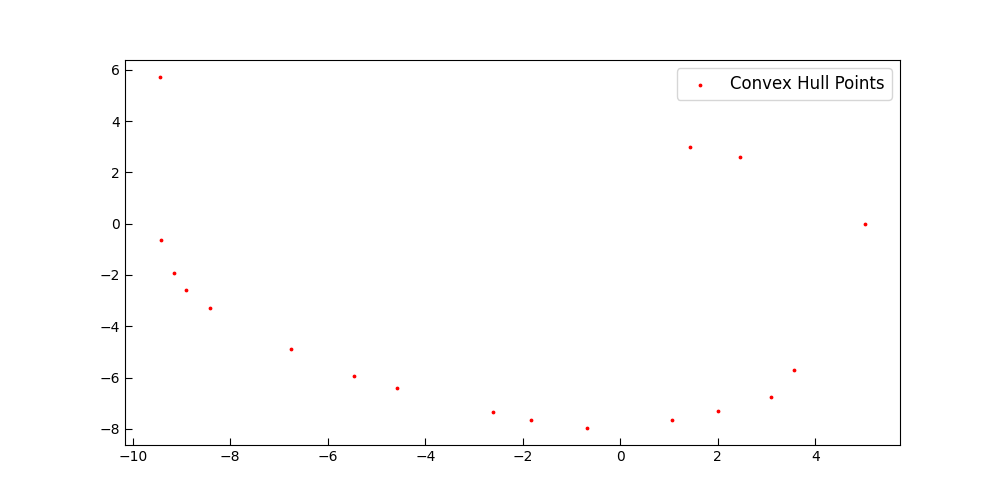


=== Processing point 21 ===


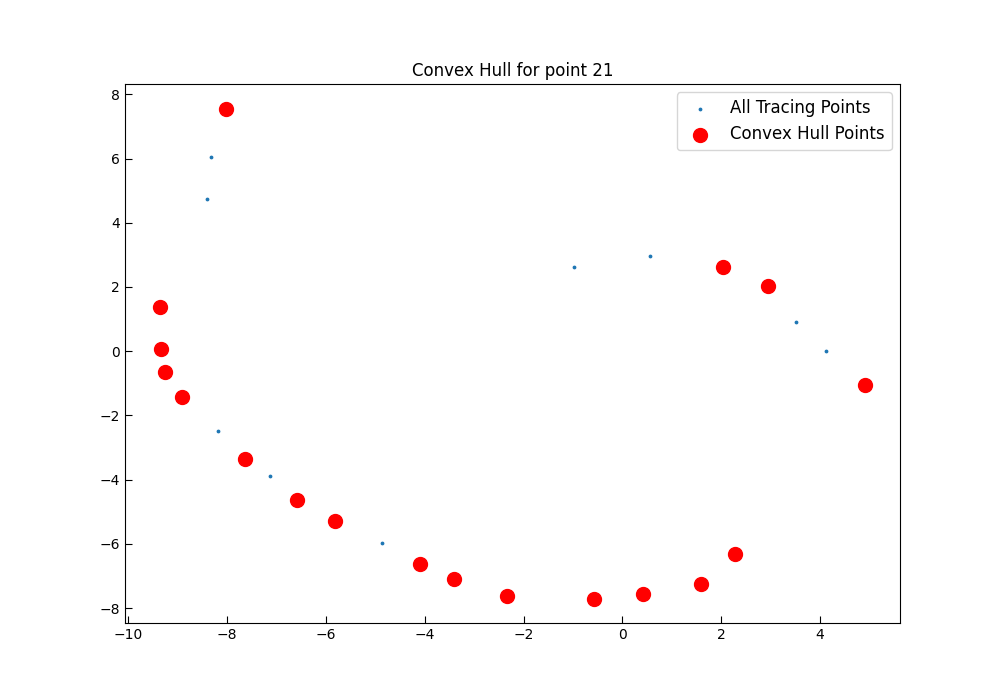

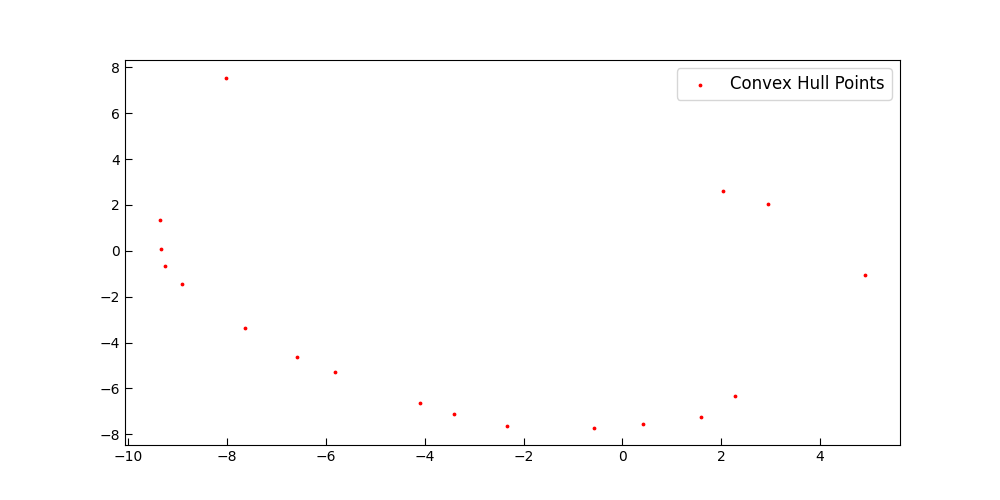


=== Processing point 22 ===


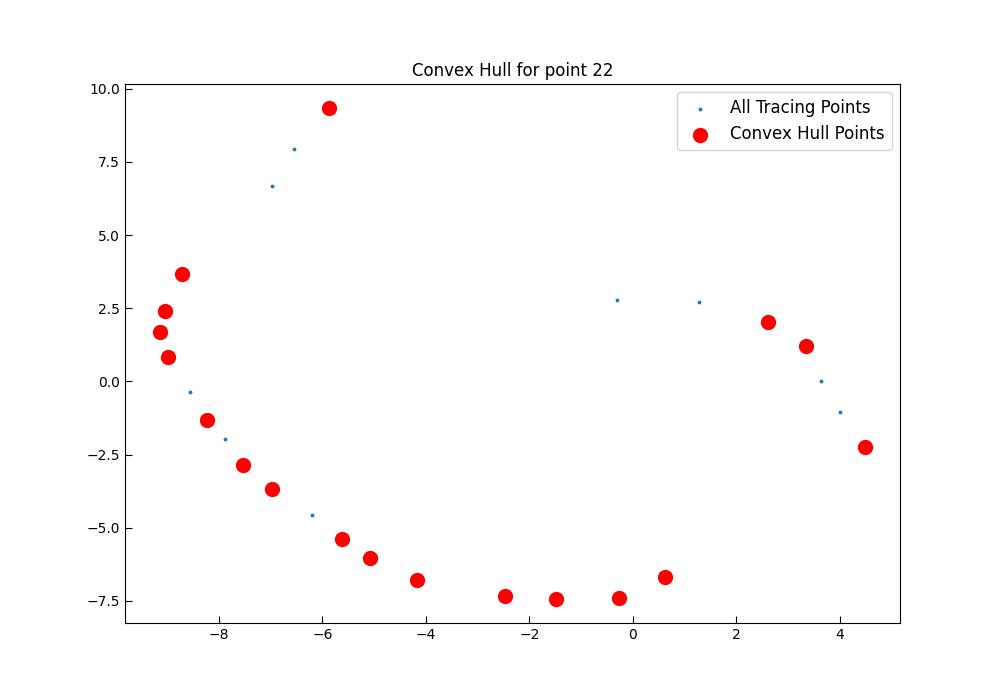

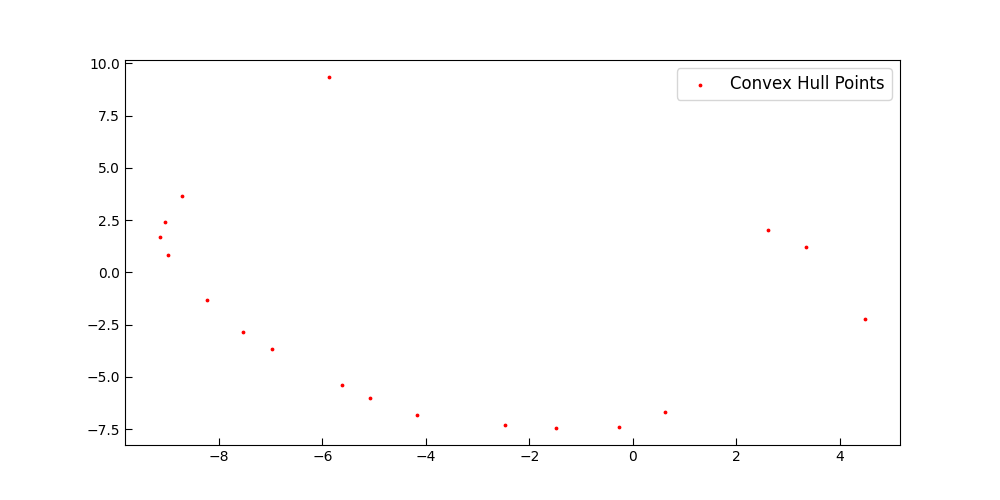


=== Processing point 23 ===


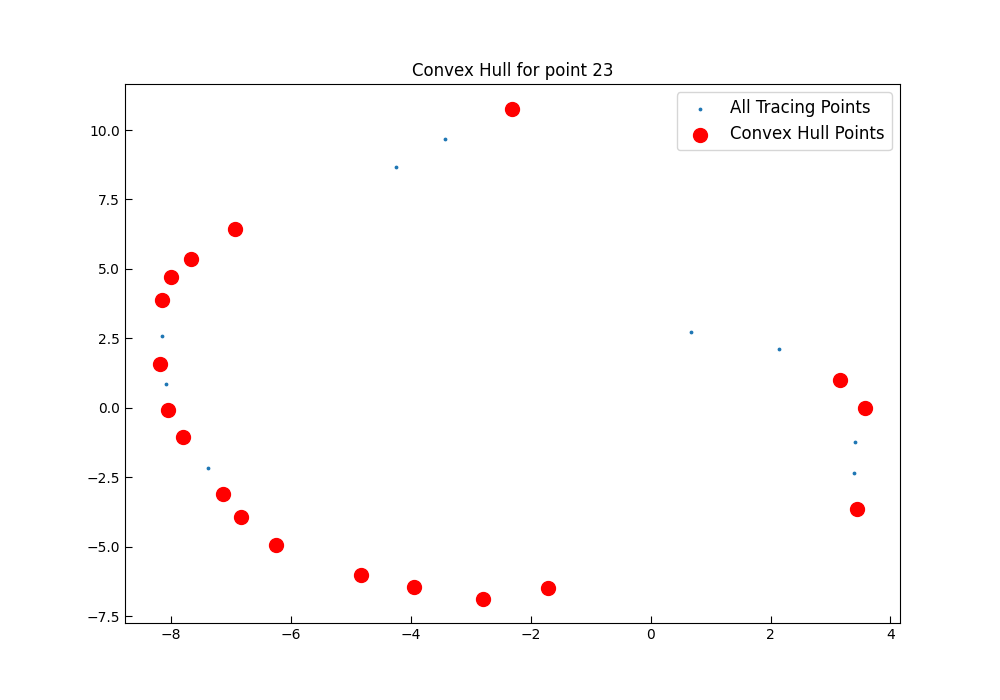

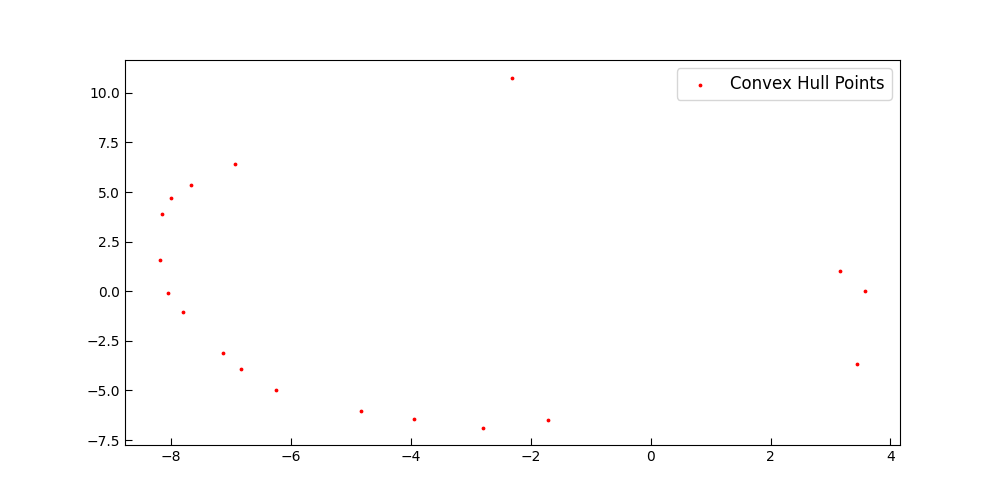


=== Processing point 24 ===


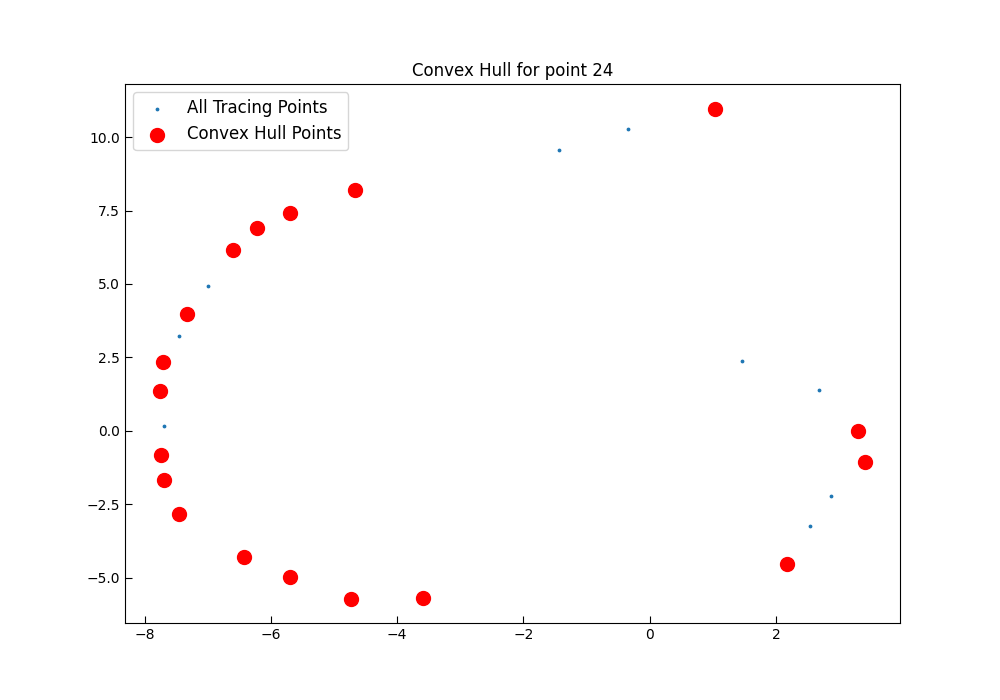

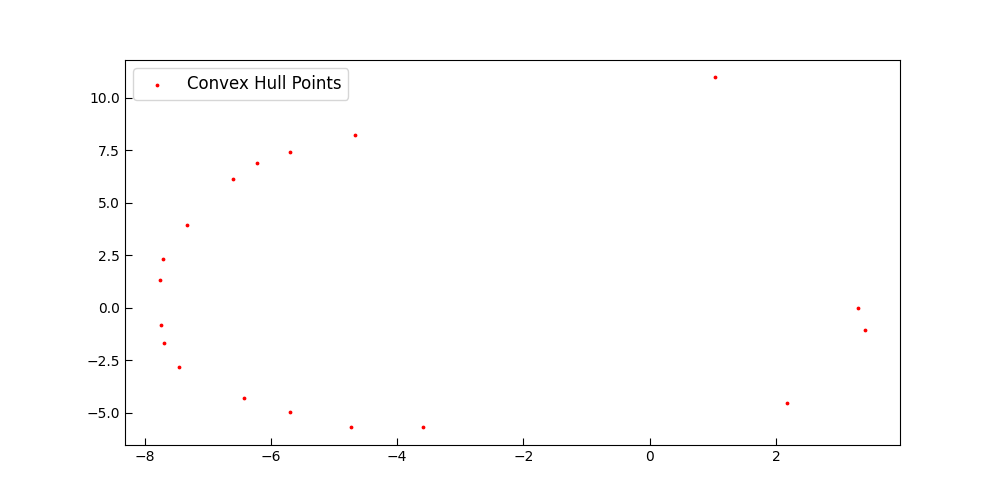


=== Processing point 25 ===


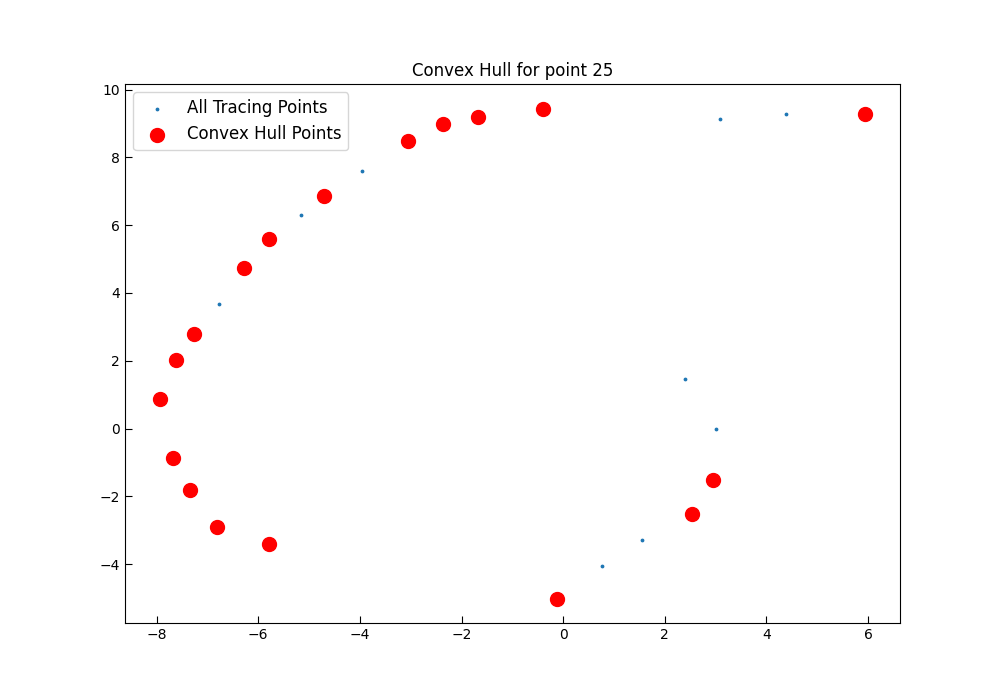

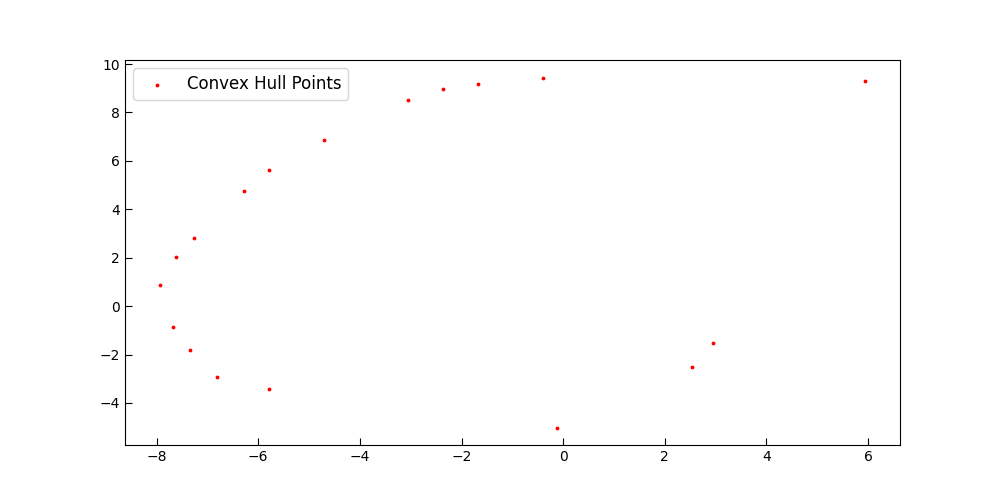


=== Processing point 26 ===


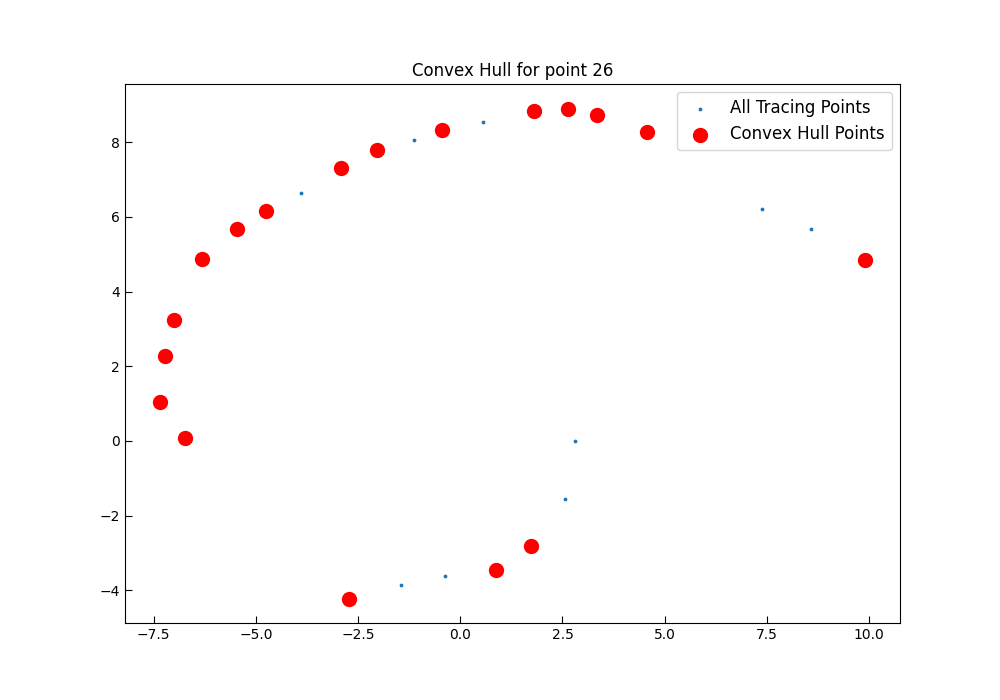

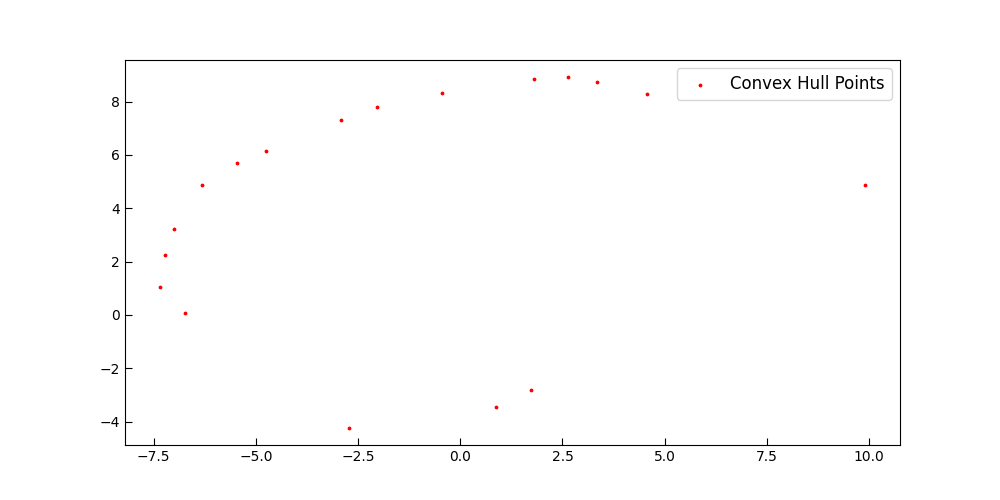

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.mixture import GaussianMixture

# Diccionario para almacenar los resultados por cada 'n'
results_dict = {}
n_values = range(1,len(arm))  # Esto tomará todos los puntos en 'arm'
# Función para calcular el Convex Hull y ajustar una Gaussiana solo con los puntos del contorno
def process_with_convex_hull(arm, n):
    # Obtener los puntos en la región de interés
    x_coords = arm.iloc[n].rotation_coords['x_rot']
    y_coords = arm.iloc[n].rotation_coords['y_rot']
    
    # Combinar los puntos en un array 2D
    points = np.column_stack((x_coords, y_coords))
    
    # Calcular el Convex Hull
    hull = ConvexHull(points)
    
    # Obtener los puntos del contorno del Convex Hull
    hull_points = points[hull.vertices]
    
    # Visualizar el Convex Hull
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(x_coords, y_coords, s=3, alpha=1, marker='o', label='Puntos')
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')
    ax.set_title(f"Convex Hull for point {n}")
    
    plt.show()

    # Ajuste Gaussiano usando Gaussian Mixture Model (GMM) solo con los puntos del contorno del Convex Hull
    gmm = GaussianMixture(n_components=1)
    gmm.fit(hull_points)
    
    # Obtener los parámetros de la Gaussiana ajustada
    mean = gmm.means_[0]
    covariances = gmm.covariances_[0]
    
    return {'mean': mean, 'covariances': covariances, 'hull': hull}

# Función para procesar después del Convex Hull (igual que el proceso después del clicker)
def process_after_convex_hull(arm, n, model, df_params, fractured):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Obtener la posición de rotación del punto n
    x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
    ax.axvline(x=x_tracing, lw=1, ls='--', color='red')

    # Obtener el perfil del brazo rotado
    x_band = arm.iloc[n].rotated_arm_profile['x_band']
    y_band = arm.iloc[n].rotated_arm_profile['y_band']
    ax.scatter(x_band, y_band, s=1, alpha=1, marker='o')

    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model(model)
    ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color='C1')
    ax.scatter(model['x_max'], model['y_max'], color='C2', marker='o')

    ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
    ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval']) + 0.05 * np.max(fitted_model['y_eval']))

    # Guardar la información de los parámetros en el DataFrame
    df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta=0.05, fractured=fractured)

    return df_params

# Función para obtener los puntos del Convex Hull
def get_convex_hull_points(x_coords, y_coords):
    points = np.column_stack((x_coords, y_coords))  # Combina los puntos x, y en coordenadas 2D
    hull = ConvexHull(points)  # Calcula el Convex Hull
    hull_points = points[hull.vertices]  # Obtén los puntos del Convex Hull
    return hull_points[:, 0], hull_points[:, 1]  # Devuelve las coordenadas x, y del Convex Hull

# Ciclo para recorrer todos los valores de n
for n in n_values:
    print(f"\n=== Processing point {n} ===")

    # Obtener los puntos de tracing rotados para el cálculo del Convex Hull
    x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
    y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
    
    # Obtén los puntos del Convex Hull
    x_hull, y_hull = get_convex_hull_points(x_tracing_all, y_tracing_all)
    
    # Parte antes del ajuste Gaussiano usando Convex Hull
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(x_tracing_all, y_tracing_all, s=3, alpha=1, label='All Tracing Points')
    ax.scatter(x_hull, y_hull, s=100, alpha=1, label='Convex Hull Points', color='red')
    
    ax.legend()
    ax.set_title(f'Convex Hull for point {n}')
    plt.show()

    # Ajuste Gaussiano solo para los puntos del Convex Hull
    # Aquí llamas las funciones tal como lo hacías después del clicker, pero usando x_hull, y_hull

    # Parte después del Convex Hull - Ajuste Gaussiano
    dict_lims = {"x_min": np.min(x_hull), "x_max": np.max(x_hull)}  # Ejemplo de límites
    
    # Ajuste gaussiano usando solo los puntos del Convex Hull
    delta = 0.05
    #model = get_asym_gaussian_fit(dict_lims, arm, n, delta)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x_hull, y_hull, s=3, alpha=1, label='Convex Hull Points', color='red')

    # Visualizar el modelo ajustado
    #fitted_model = eval_fitted_model(model)
    #ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color='C1', label='Fitted Model')
    #ax.scatter(model['x_max'], model['y_max'], color='C2', marker='o', label='Model Max')

    ax.legend()
    plt.show()

    # Almacenar en DataFrame
    fractured = False
    #df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)


(-4.0, 4.0)

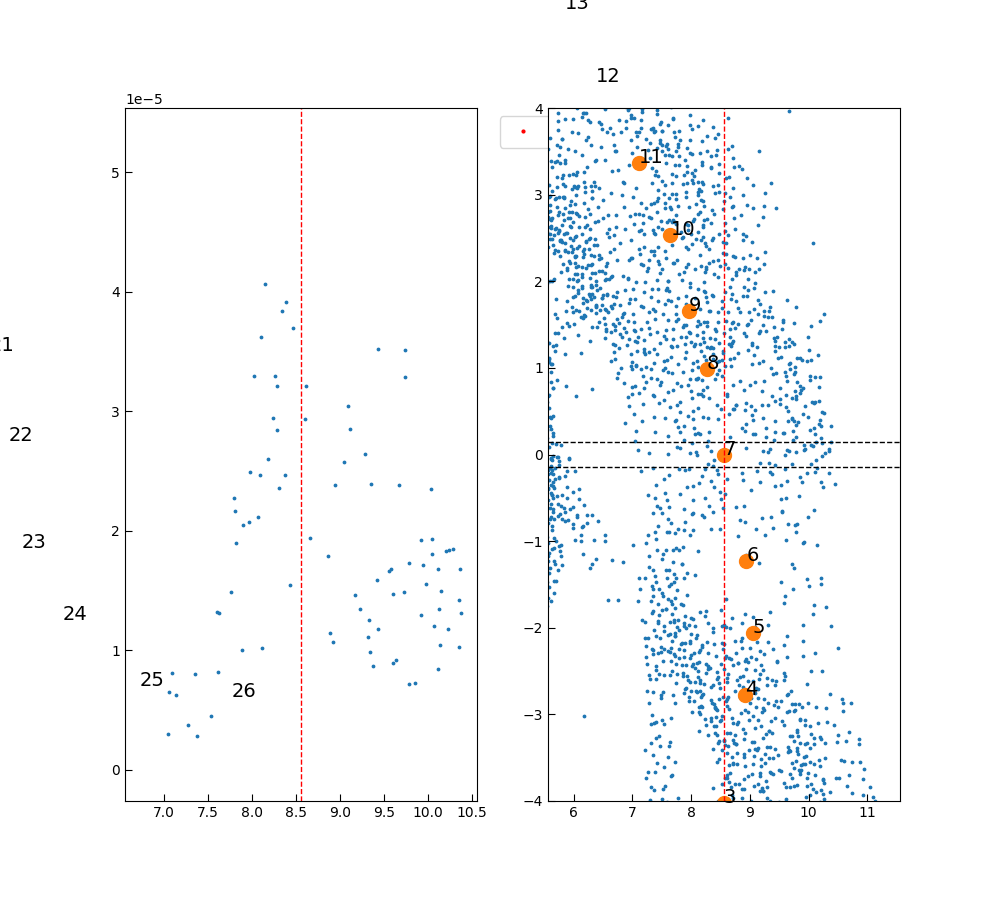

In [41]:
%matplotlib widget

n= 7 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-4,4)

## %run Routines_and_data/gauss_asym.py

In [60]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [61]:
dict_lims

{'limits': array([[6.99102100e+00, 2.26914757e-06],
        [6.99102100e+00, 3.69292644e-06],
        [7.05915003e+00, 5.61921550e-06],
        [7.12727906e+00, 6.87549097e-06],
        [7.20676293e+00, 8.46677324e-06],
        [7.29760164e+00, 1.00580555e-05],
        [7.35437583e+00, 1.21518480e-05],
        [7.38844035e+00, 1.47481506e-05],
        [7.45656938e+00, 1.60044261e-05],
        [7.52469842e+00, 1.73444532e-05],
        [7.57011777e+00, 1.91869906e-05],
        [7.64960164e+00, 2.14482865e-05],
        [7.79721454e+00, 2.38770857e-05],
        [7.84263390e+00, 2.63058850e-05],
        [7.88805325e+00, 2.95722012e-05],
        [7.94482745e+00, 3.12472352e-05],
        [8.01295648e+00, 3.40110412e-05],
        [8.21734358e+00, 3.69423506e-05],
        [8.35360164e+00, 3.97061567e-05],
        [8.56934358e+00, 4.07111770e-05],
        [8.68289196e+00, 4.02086669e-05],
        [8.89863390e+00, 3.87011363e-05],
        [9.05760164e+00, 3.67748472e-05],
        [9.33011777e+00,

In [62]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [63]:
n

7

(1.038700206858786e-18, 2.8928134911295665e-05)

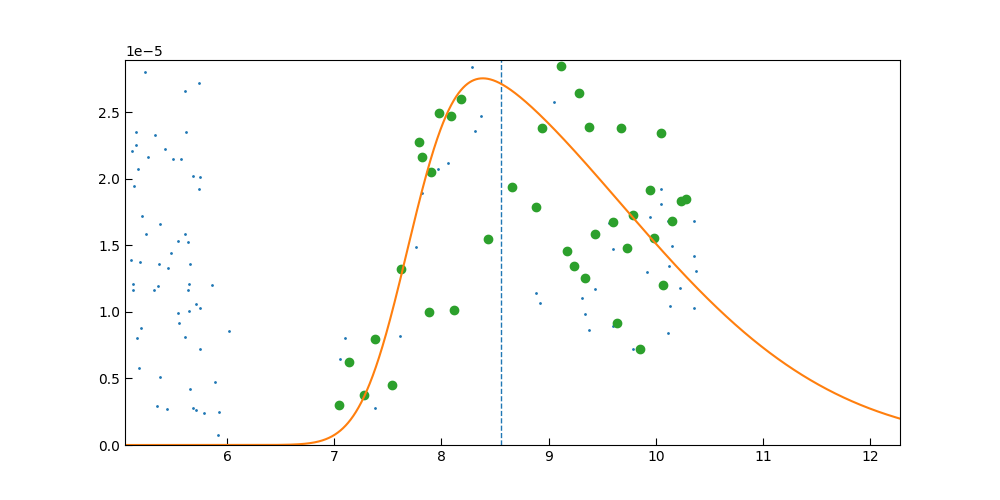

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [65]:
fractured = False

In [68]:
df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [69]:
df_params.tail()

amplitude    center  delta fractured     gamma  id_tracing     sigma  \
0   0.000062  7.779178   0.05     False  3.256871         7.0  1.428761   
1   0.000074  7.694545   0.05     False  5.470631         7.0  1.963680   

   stderr_amplitude  stderr_center  stderr_gamma  stderr_sigma  \
0          0.000006       0.112887      1.739026      0.278157   
1          0.000007       0.092051      2.570449      0.318829   

                                                   x  x_tracing  \
0  [7.140513619787687, 7.278780859643688, 7.37889...    2.11039   
1  [7.049161552851497, 7.140513619787687, 7.27878...    2.11039   

                                                   y  y_tracing  
0  [8.070066093515586e-06, 3.741778185339923e-06,...  -8.293831  
1  [3.000142740849324e-06, 6.262135655477005e-06,...  -8.293831

In [70]:
df_params

amplitude    center  delta fractured     gamma  id_tracing     sigma  \
0   0.000062  7.779178   0.05     False  3.256871         7.0  1.428761   
1   0.000074  7.694545   0.05     False  5.470631         7.0  1.963680   

   stderr_amplitude  stderr_center  stderr_gamma  stderr_sigma  \
0          0.000006       0.112887      1.739026      0.278157   
1          0.000007       0.092051      2.570449      0.318829   

                                                   x  x_tracing  \
0  [7.140513619787687, 7.278780859643688, 7.37889...    2.11039   
1  [7.049161552851497, 7.140513619787687, 7.27878...    2.11039   

                                                   y  y_tracing  
0  [8.070066093515586e-06, 3.741778185339923e-06,...  -8.293831  
1  [3.000142740849324e-06, 6.262135655477005e-06,...  -8.293831

In [71]:
df_params['y']

0    [8.070066093515586e-06, 3.741778185339923e-06,...
1    [3.000142740849324e-06, 6.262135655477005e-06,...
Name: y, dtype: object

In [72]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 7.41459e-05
center                                                        7.69454
delta                                                            0.05
fractured                                                       False
gamma                                                         5.47063
id_tracing                                                          7
sigma                                                         1.96368
stderr_amplitude                                          7.01879e-06
stderr_center                                               0.0920508
stderr_gamma                                                  2.57045
stderr_sigma                                                 0.318829
x                   [7.049161552851497, 7.140513619787687, 7.27878...
x_tracing                                                     2.11039
y                   [3.000142740849324e-06, 6.262135655477005e-06,...
y_tracing           

In [73]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [74]:
arm.iloc[n].id

7

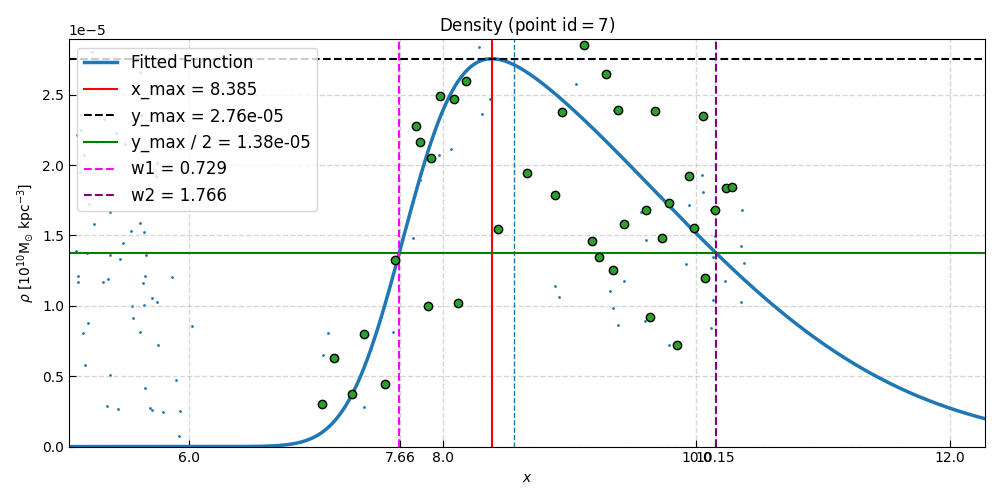

In [75]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

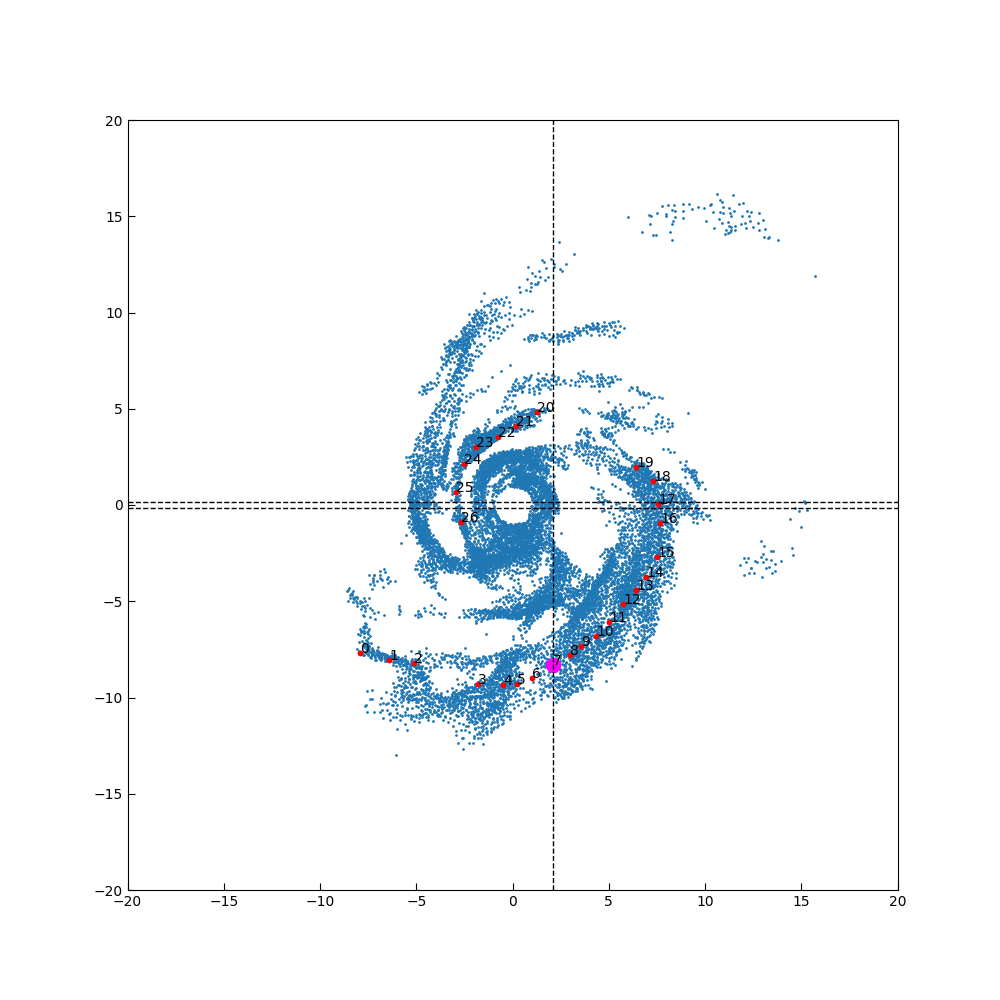

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [77]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}_.csv', index = False)

In [78]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

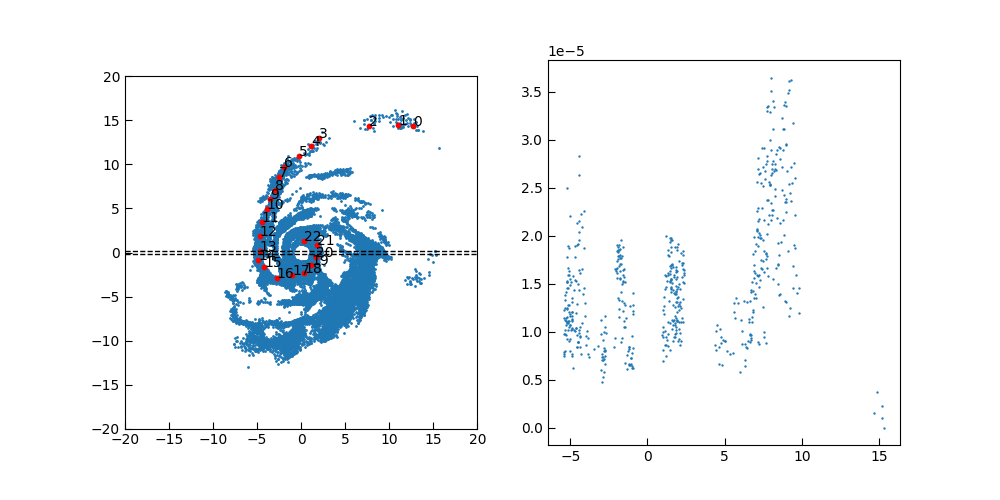

In [79]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [95]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [96]:
arm

x          y  arm  id
0   12.707792  14.355519    1   0
1   10.993506  14.459416    1   1
2    7.668831  14.407468    1   2
3    2.006494  12.952922    1   3
4    1.175325  12.069805    1   4
5   -0.279221  10.926948    1   5
6   -1.941558   9.680195    1   6
7   -2.512987   8.537338    1   7
8   -2.928571   7.082792    1   8
9   -3.551948   6.095779    1   9
10  -3.915584   4.952922    1  10
11  -4.487013   3.498377    1  11
12  -4.694805   1.887987    1  12
13  -4.694805   0.225649    1  13
14  -4.902597  -0.813312    1  14
15  -4.175325  -1.592532    1  15
16  -2.772727  -2.839286    1  16
17  -1.006494  -2.527597    1  17
18   0.344156  -2.319805    1  18
19   1.123377  -1.436688    1  19
20   1.694805  -0.553571    1  20
21   1.746753   0.900974    1  21
22   0.344156   1.316558    1  22

AttributeError: 'Series' object has no attribute 'This_tracingPoint_rot'

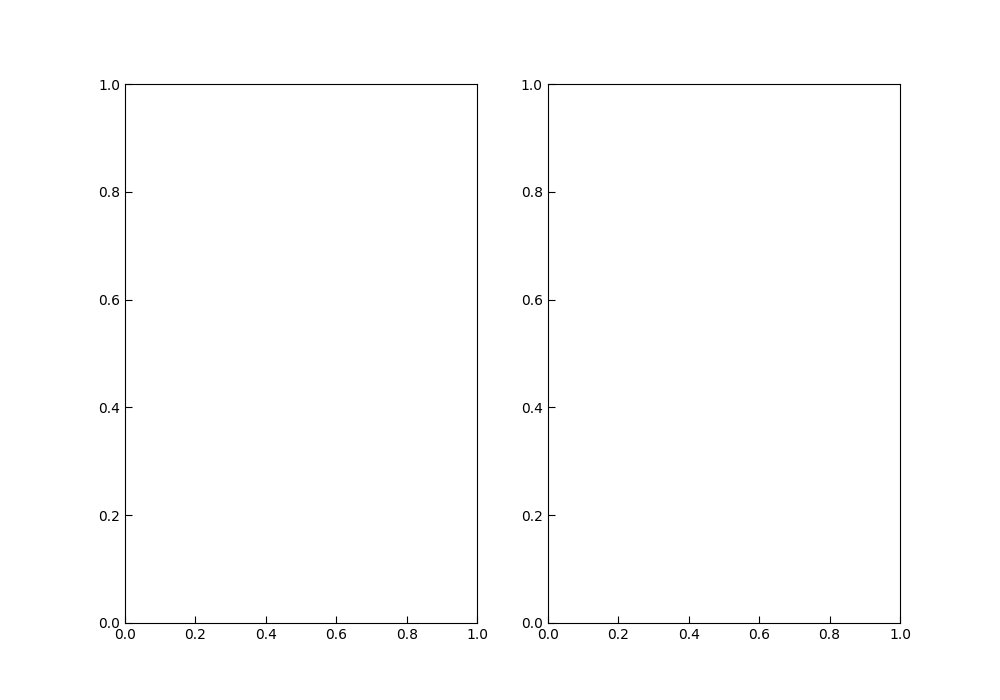

In [97]:
n= 14 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [84]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [85]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(3.646652144509628e-20, 1.3586121677327436e-05)

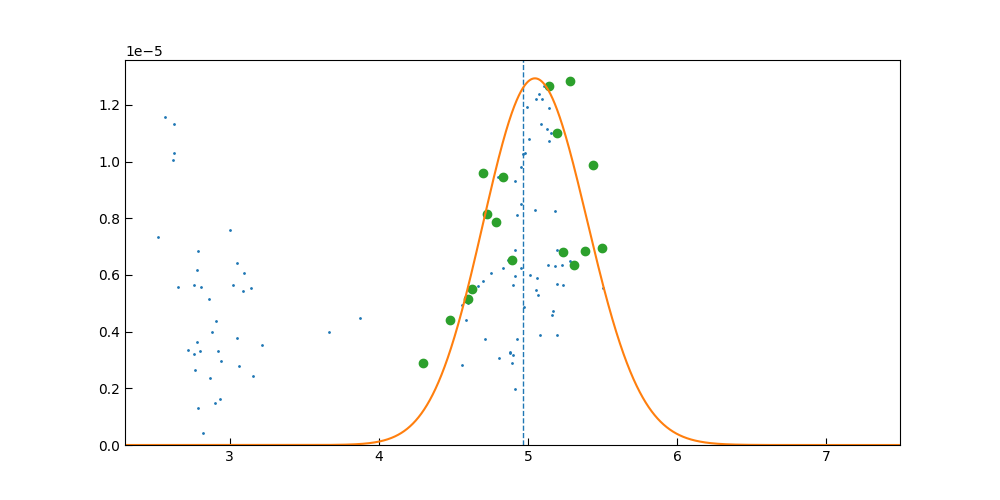

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [87]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

/home/daniel/Documentos/UdeA/SpiralStructure_IllustrisTNG50/ROUTINES/gauss_asym.py:137: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, pd.DataFrame.from_records([dict_values])], ignore_index=True)


In [88]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 1.13657e-05
center                                                        4.87937
delta                                                            0.05
fractured                                                       False
gamma                                                        0.686374
id_tracing                                                         14
sigma                                                        0.393644
stderr_amplitude                                          1.36373e-06
stderr_center                                                0.889328
stderr_gamma                                                  4.44307
stderr_sigma                                                  0.49581
x                   [4.298750736065823, 4.480197704769558, 4.59564...
x_tracing                                                     -4.9026
y                   [2.877623224295711e-06, 4.410360268359912e-06,...
y_tracing           

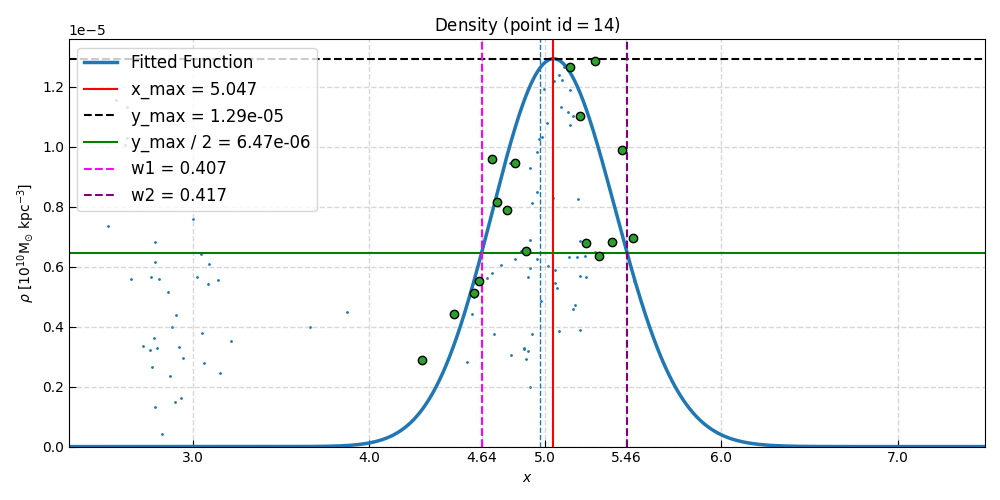

In [89]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_HALO{id_halo}_.png',dpi=200)

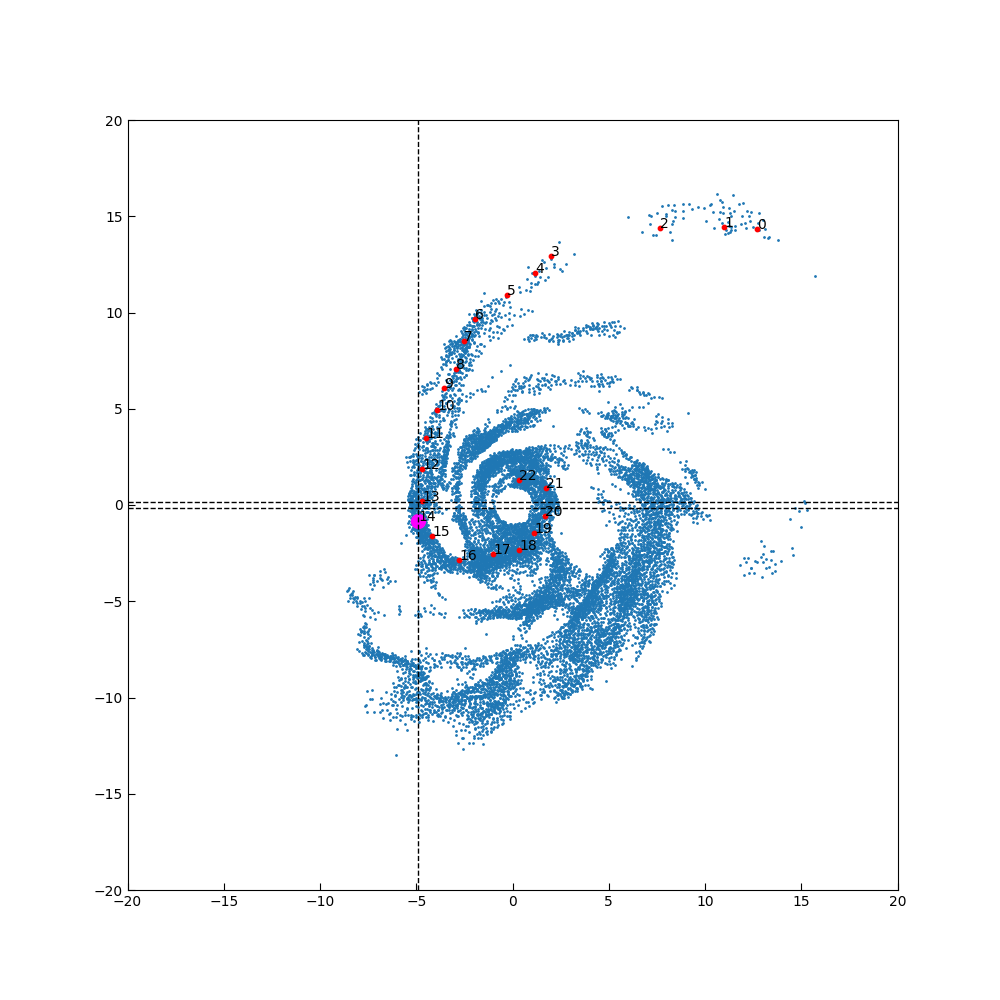

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [91]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)
